## Kaggle :  House Prices - Advanced Regression Techniques
- Kernel : Detailed Data Analysis & Ensemble Modeling
- Worker : Kim Soojung 
- 2018 - 04- 18 

In [112]:
# 필요한 패키지 다운로드
require(ggplot2) # for data visualization
require(stringr) #extracting string patterns
require(Matrix) # matrix transformations
require(glmnet) # ridge, lasso & elastinet
require(xgboost) # gbm
require(randomForest)
require(Metrics) # rmse
require(dplyr) # load this in last so plyr doens't overlap it
require(caret) # one hot encoding
require(scales) # plotting $$
require(e1071) # skewness
require(corrplot) # correlation plot
require(magrittr) # function '%>%'
library(dplyr) # function 'group by'
require(GGally)

Loading required package: glmnet
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'glmnet'"Loading required package: Metrics
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'Metrics'"Loading required package: GGally
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'GGally'"

In [8]:
# 데이터 다운로드
# 1.분석을 의미있게하기 위해 train set 과 test set 을 병합하여 분석한다. 
# 2.model 을 학습하기 전에 다시 원래대로 나눈다. 

train <- read.csv('C:/WORK/Kaggle/Project_House Price/HousePrice/Data/train.csv', stringsAsFactors = FALSE)
test <- read.csv('C:/WORK/Kaggle/Project_House Price/HousePrice/Data/test.csv', stringsAsFactors = FALSE)

# 1.combine the train set and test set (with rbind)
# Id, SalePrice 삭제
df.combined <- rbind(within(train, rm('Id','SalePrice')), within(test, rm('Id')))
cat("data frame : ",dim(df.combined))

data frame :  2919 79

In [9]:
head(train)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,...,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


- # 데이터 전처리

In [10]:
# 결측치를 가진 feature 확인 
# 데이터 셋에서 na가 있는 컬럼이 0이상일 조건을 만족하는 변수 => na.cols
na.cols <- which(colSums(is.na(df.combined)) >0)

# 데이터 셋의 na.col 중에서 na의 개수를 세서 내림차순으로 벡터화.
sort(colSums(sapply(df.combined[na.cols], is.na)), decreasing = TRUE)

# 총 na가 포함된 col 수
paste('There are', length(na.cols), 'columns with missing values')

PoolQC  MiscFeature        Alley        Fence  FireplaceQu  LotFrontage 
        2909         2814         2721         2348         1420          486 
 GarageYrBlt GarageFinish   GarageQual   GarageCond   GarageType     BsmtCond 
         159          159          159          159          157           82 
BsmtExposure     BsmtQual BsmtFinType2 BsmtFinType1   MasVnrType   MasVnrArea 
          82           81           80           79           24           23 
    MSZoning    Utilities BsmtFullBath BsmtHalfBath   Functional  Exterior1st 
           4            2            2            2            2            1 
 Exterior2nd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF   Electrical 
           1            1            1            1            1            1 
 KitchenQual   GarageCars   GarageArea     SaleType 
           1            1            1            1

[1] "There are 34 columns with missing values"

In [11]:
# categoric 데이터를 시각화하는 plot
plot.categoric <- function(cols, df){
        for(col in cols){
                order.cols <- names(sort(table(df.combined[,col]), decreasing =TRUE))
                
                num.plot <- qplot(df[,col]) +
                        geom_bar(fill = 'cornflowerblue') +
                        geom_text(aes(label = ..count..), stat ='count', vjust=-0.5) +
                        theme_minimal() +
                        scale_y_continuous(limits = c(0, max(table(df[,col]))*1.1)) +
                        scale_x_discrete(limits = order.cols) +
                        xlab(col) +
                        theme(axis.text.x = element_text(angle = 30, size=12))
                
                 print(num.plot)
        }
}

- ## PoolQC : Pool Quality

Warning message:
"Removed 2909 rows containing non-finite values (stat_count)."Warning message:
"Removed 2909 rows containing non-finite values (stat_count)."Warning message:
"Removed 2909 rows containing non-finite values (stat_count)."

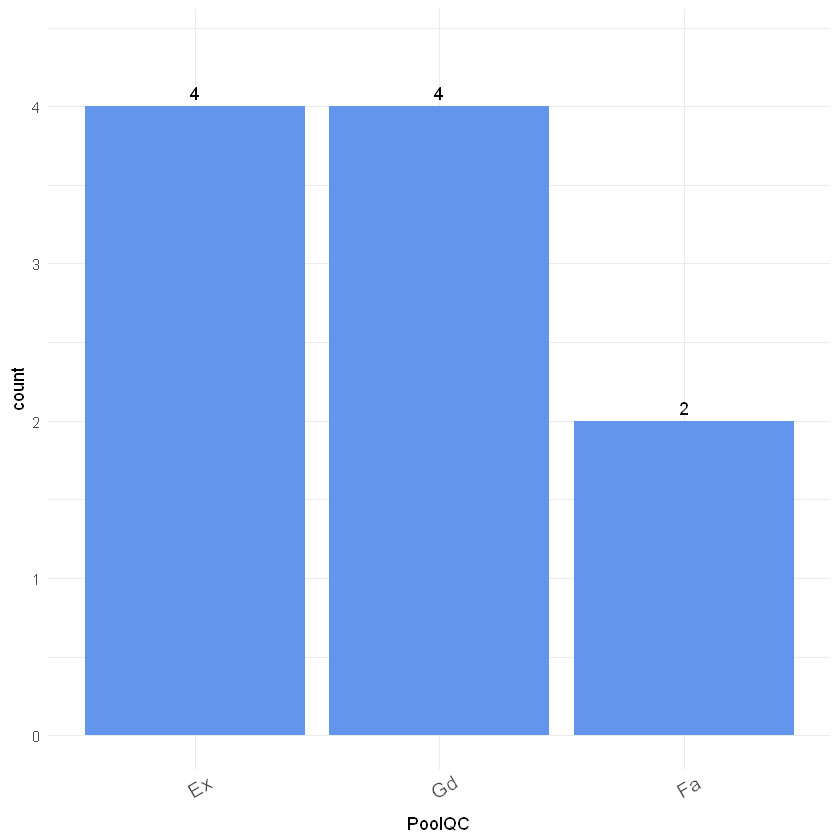

In [12]:
plot.categoric('PoolQC', df.combined)

In [13]:
#PoolArea >0 인 것 중에서 PoolQC 가 na 인것 확인
df.combined[(df.combined$PoolArea >0) & is.na(df.combined$PoolQC), c('PoolQC', 'PoolArea')]

# 위의 조건을 만족하는 것(NA)의 결측치 처리과정 
# PoolArea 와 비교하여 대체. 
df.combined[,c('PoolQC', 'PoolArea')] %>% 
        group_by(PoolQC) %>%
        summarise(mean = mean(PoolArea), counts = n())
df.combined[2421,'PoolQC'] = 'Ex'
df.combined[2504,'PoolQC'] = 'Ex'
df.combined[2600,'PoolQC'] = 'Fa'
df.combined$PoolQC[is.na(df.combined$PoolQC)] = 'None'

,PoolQC,PoolArea
2421,NA,368
2504,NA,444
2600,NA,561


PoolQC,mean,counts
Ex,359.7500000,4
Fa,583.5000000,2
Gd,648.5000000,4
NA,0.4719835,2909


- ## Garage : garage(차고) 관련 변수 
    - GarageYrBlt's NA: 159

In [14]:
# 상식적으로 집이 지어진 날과 차고가 지어진 날은 같을 것이다.
length(which(df.combined$GarageYrBlt == df.combined$YearBuilt))

# GarageBYrBlt 의 결측값을 YearBuilt 와 비교하여 채운다. 
# GarageBYrBlt 의 na 값을 idx로 딴 후 YearBuilt 와 idx가 같은 값을 넣어준다.
idx <- which(is.na(df.combined$GarageYrBlt))
df.combined[idx, 'GarageYrBlt'] <- df.combined[idx, 'YearBuilt']

[1] 2216

In [15]:
# garage 관련 변수들 중에서 na값이 포함되어있는 데이터형태로 구성
# --> GarageCond

garage.cols <- c('GarageArea', 'GarageCars', 'GarageQual', 'GarageFinish', 'GarageCond', 'GarageType')
df.combined[is.na(df.combined$GarageCond),garage.cols]

,GarageArea,GarageCars,GarageQual,GarageFinish,GarageCond,GarageType
40,0,0,NA,NA,NA,NA
49,0,0,NA,NA,NA,NA
79,0,0,NA,NA,NA,NA
89,0,0,NA,NA,NA,NA
90,0,0,NA,NA,NA,NA
100,0,0,NA,NA,NA,NA
109,0,0,NA,NA,NA,NA
126,0,0,NA,NA,NA,NA
128,0,0,NA,NA,NA,NA
141,0,0,NA,NA,NA,NA


In [16]:
# Row 2127 은 수동으로 NA의 값을 채워줄 수 있다. 

idx <-which(((df.combined$GarageArea < 370) & (df.combined$GarageArea > 350)) & (df.combined$GarageCars == 1))
cat(idx)

names(sapply(df.combined[idx, garage.cols], function(x) sort(table(x), decreasing = TRUE)[1]))
             
df.combined[2127,'GarageQual'] = 'TA'
df.combined[2127, 'GarageFinish'] = 'Unf'
df.combined[2127, 'GarageCond'] = 'TA'

13 15 60 99 195 243 331 388 428 439 460 463 544 580 628 839 894 997 1054 1171 1214 1363 1542 1555 1572 1590 1618 1782 1792 1818 1918 1963 2120 2127 2200 2215 2216 2279 2286 2419 2431 2435 2556 2559 2588 2744 2861

[1] "GarageArea.352"    "GarageCars.1"      "GarageQual.TA"    
[4] "GarageFinish.Unf"  "GarageCond.TA"     "GarageType.Attchd"

In [17]:
# garage area 와 garage car가 0인 경우는 garage가 없다고 판단하여 garage 관련한 NA값들을 다 '0'으로 채운다.
# garage.cols = garage 관련 변수들 
for(col in garage.cols){
    if(sapply(df.combined[col], is.numeric) == TRUE){
        df.combined[sapply(df.combined[col], is.na), col] = 0
    }
    else{
        df.combined[sapply(df.combined[col], is.na), col] = 'None'
    }
}

- ## KitchenQual: Kitchen quality
    - kitchenQual 의 NA 는 한개이다. 이는 최빈값으로 처리.

Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."

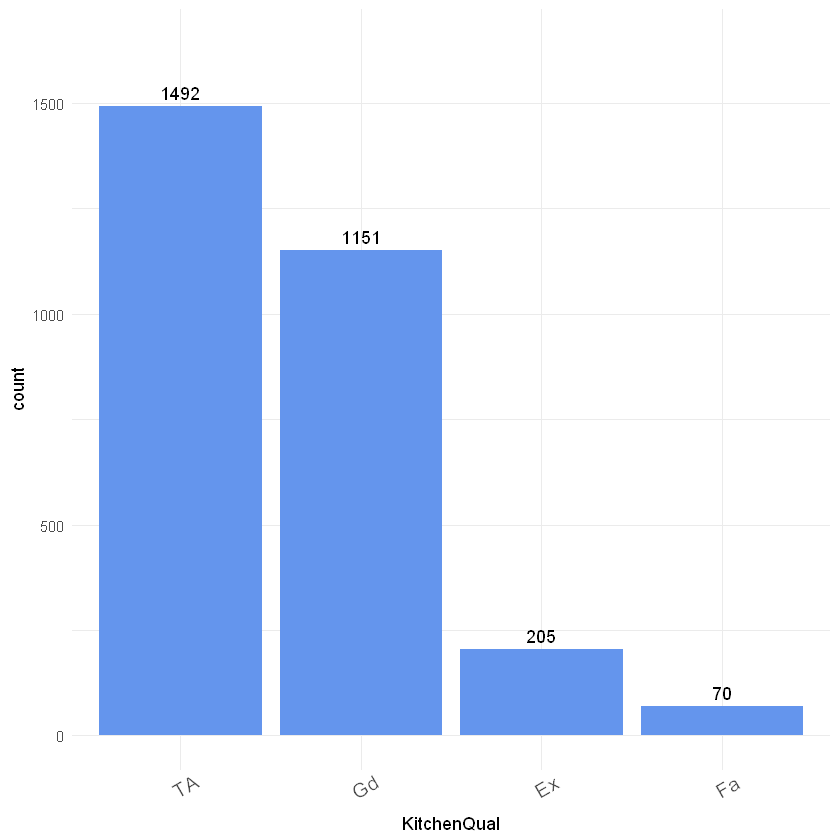

In [18]:
plot.categoric('KitchenQual', df.combined)

df.combined$KitchenQual[is.na(df.combined$KitchenQual)] = 'TA'


- ## Electrical 
    - KitchenQual 과 마찬가지로 NA 값 1개 --> 최빈값 처리

Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."

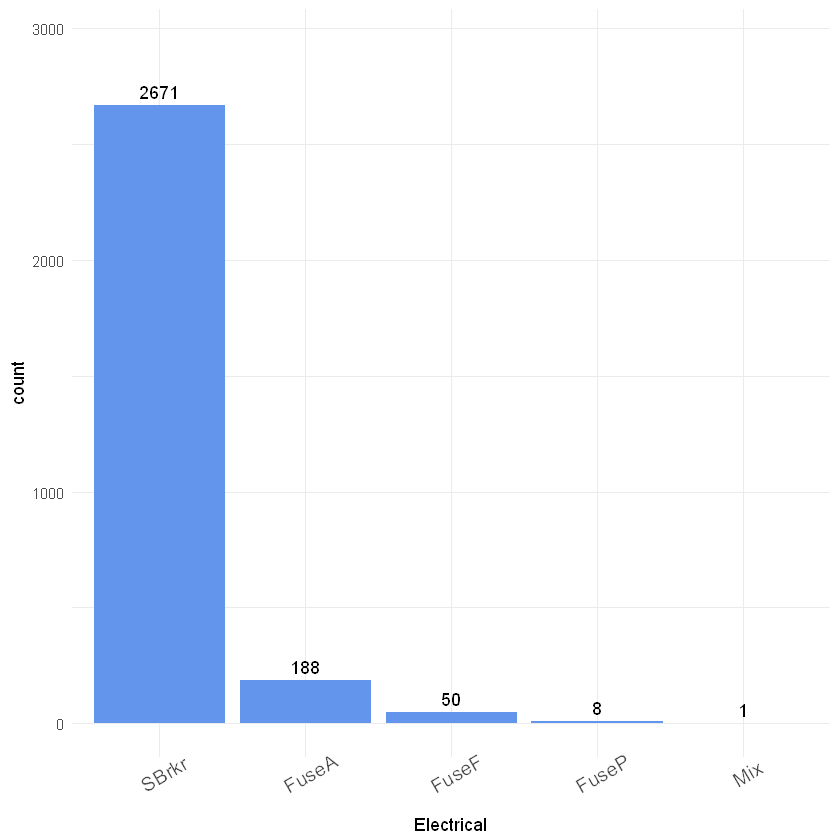

In [19]:
plot.categoric('Electrical', df.combined)

df.combined$Electrical[is.na(df.combined$Electrical)] = 'SBrkr'

- ## Basement 관련 변수
    - BsmtQual: Height of the basement
    - BsmtCond: General condition of the basement
    - BsmtExposure: Walkout or garden level basement walls
    - BsmtFinType1: Quality of basement finished area
    - BsmtFinSF1: Type 1 finished square feet
    - BsmtFinType2: Quality of second finished area (if present)
    - BsmtFinSF2: Type 2 finished square feet
    - BsmtUnfSF: Unfinished square feet of basement area
    - TotalBsmtSF: Total square feet of basement area
    - BsmtFullBath: Basement full bathrooms
    - BsmtHalfBath: Basement half bathrooms

In [20]:
# basement 관련 변수들 특징파악 (NA갯수) --> 하나의 변수로 정리
bsmt.cols <- names(df.combined)[sapply(names(df.combined), function(x) str_detect(x, 'Bsmt'))]

df.combined[is.na(df.combined$BsmtExposure), bsmt.cols]                                

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
18,NA,NA,NA,NA,0,NA,0,0,0,0,0
40,NA,NA,NA,NA,0,NA,0,0,0,0,0
91,NA,NA,NA,NA,0,NA,0,0,0,0,0
103,NA,NA,NA,NA,0,NA,0,0,0,0,0
157,NA,NA,NA,NA,0,NA,0,0,0,0,0
183,NA,NA,NA,NA,0,NA,0,0,0,0,0
260,NA,NA,NA,NA,0,NA,0,0,0,0,0
343,NA,NA,NA,NA,0,NA,0,0,0,0,0
363,NA,NA,NA,NA,0,NA,0,0,0,0,0
372,NA,NA,NA,NA,0,NA,0,0,0,0,0


- ### BsmtExposure

Warning message:
"Removed 82 rows containing non-finite values (stat_count)."Warning message:
"Removed 82 rows containing non-finite values (stat_count)."Warning message:
"Removed 82 rows containing non-finite values (stat_count)."

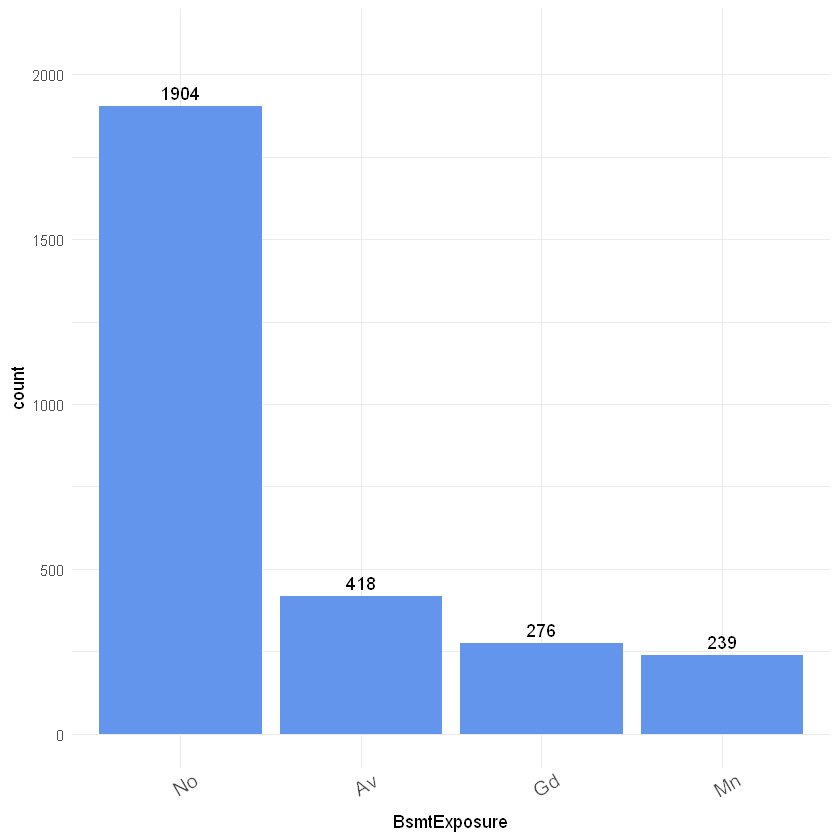

In [21]:
plot.categoric('BsmtExposure', df.combined)

In [22]:
# Row 949, 1488, 2349 는 bsmtExposure에만 NA값이 있다 --> 최빈값으로 처리
df.combined[c(949, 1488, 2349), 'BsmtExposure'] = 'No'

for(col in bsmt.cols){
    if(sapply(df.combined[col], is.numeric) == TRUE){
        df.combined[sapply(df.combined[col], is.na), col] = 0
    }
    else{
        df.combined[sapply(df.combined[col], is.na), col] = 'None'
    }
}

- ## Exterior : 외부
    - Exterior1st : 집안의 외장
    - Exterior2nd : 주택의 외장 (1개의 재료이상)

Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."

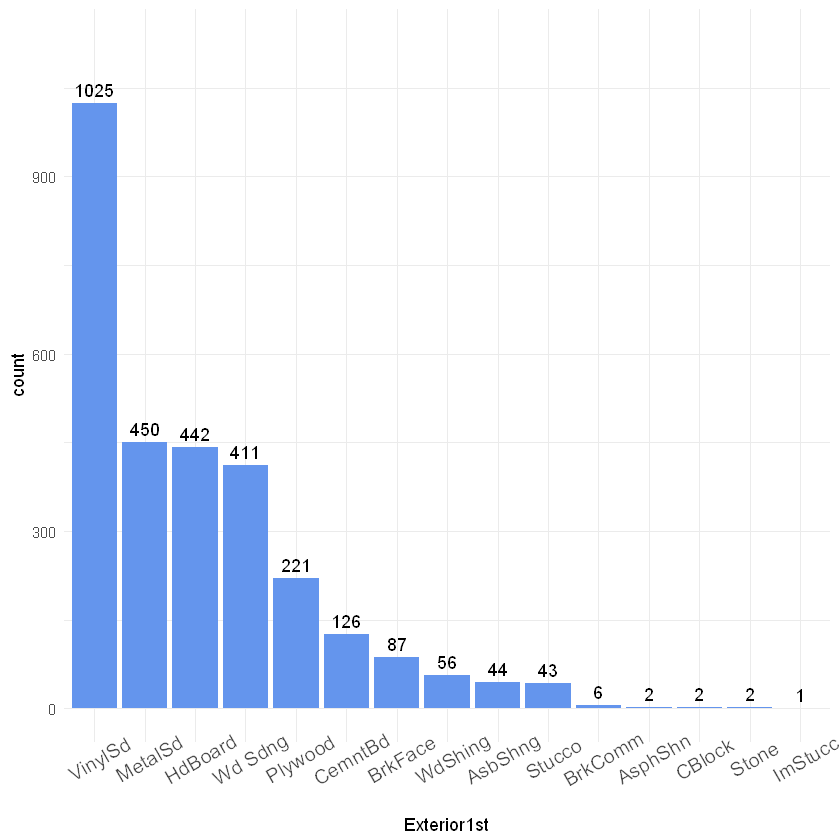

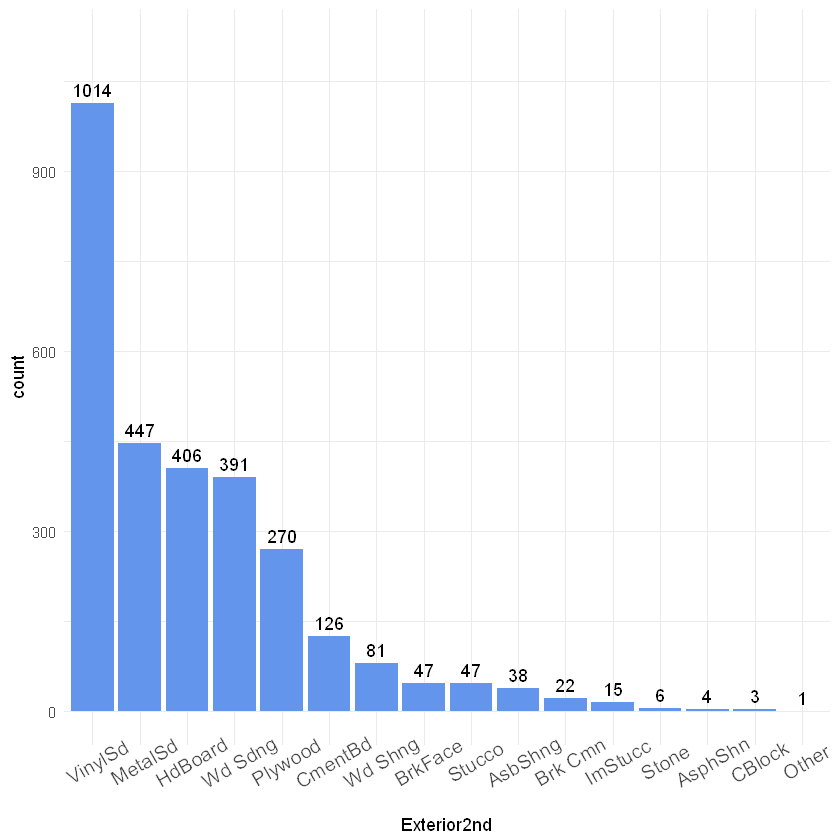

In [23]:
plot.categoric(c('Exterior1st', 'Exterior2nd'), df.combined)

In [24]:
idx <- which(is.na(df.combined$Exterior1st) | is.na(df.combined$Exterior2nd))
df.combined[idx, c('Exterior1st', 'Exterior2nd')]

,Exterior1st,Exterior2nd
2152,NA,NA


In [25]:
# Row 2152 의 한개의 결측값이 있다. 이는 아마 다른 외장재료를 써서 결측값이 되었을꺼라고 예상하여 'other' 로 처리한다.
df.combined$Exterior1st[is.na(df.combined$Exterior1st)] = 'Other'
df.combined$Exterior2nd[is.na(df.combined$Exterior2nd)] = 'Other'

- ### SaleType: Type of sale

Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."

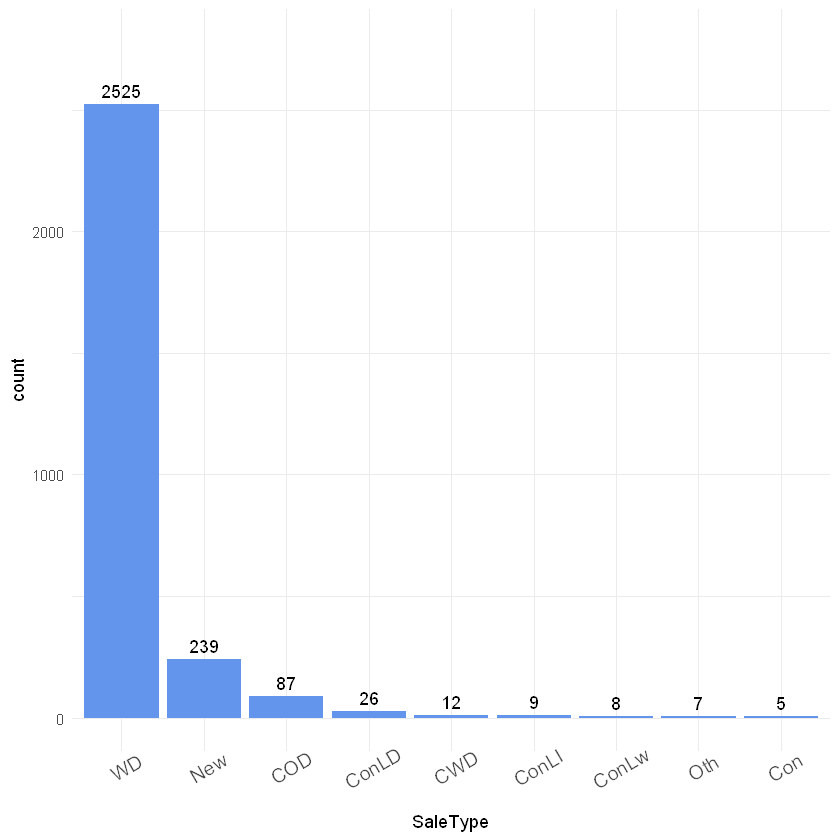

In [28]:
# 결측치 1개
plot.categoric('SaleType', df.combined)

In [30]:
# SaleType 결측치의 SaleCondition 
df.combined[is.na(df.combined$SaleType), c('SaleCondition')]
table(df.combined$SaleCondition, df.combined$SaleType)

[1] "Normal"

         
           COD  Con ConLD ConLI ConLw  CWD  New  Oth   WD
  Abnorml   46    0     3     2     0    1    0    5  133
  AdjLand    0    0     0     0     0    0    0    0   12
  Alloca     0    0     0     0     0    0    0    0   24
  Family     2    0     1     2     1    1    0    1   38
  Normal    39    4    21     5     7   10    0    1 2314
  Partial    0    1     1     0     0    0  239    0    4

In [31]:
# 위의 테이블을 참조하면 (SaleType 과 SaleCondition의 관계 테이블)
# SaleCondition,' Normal' --> 최빈값 --> SaleType, 'WD'
# SaleType 의 최빈값 또한 -> 'WD'
df.combined$SaleType[is.na(df.combined$SaleType)] = "WD"

- ### Functional: Home functionality rating

Functional_na_index : 2919

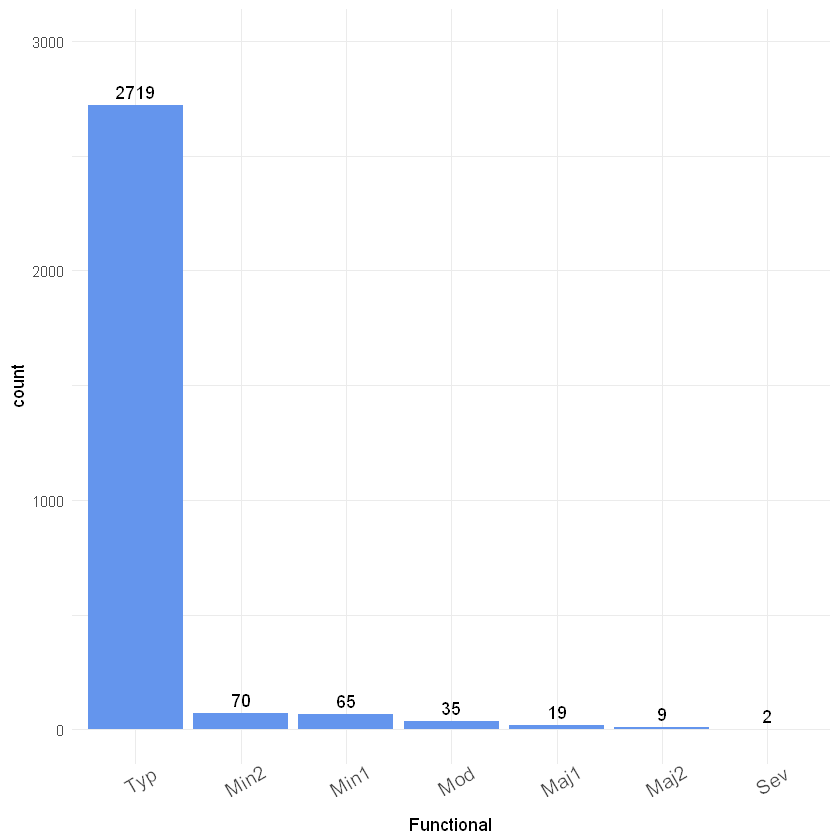

In [44]:
plot.categoric('Functional', df.combined)
cat("Functional_na_index :",length(is.na(df.combined$Functional)))

In [41]:
# Functional 의 최빈값으로 결측치 처리
df.combined$Functional[is.na(df.combined$Functional)] = 'Typ'

- ### Utilities: Type of utilities available

Warning message:
"Removed 2 rows containing non-finite values (stat_count)."Warning message:
"Removed 2 rows containing non-finite values (stat_count)."Warning message:
"Removed 2 rows containing non-finite values (stat_count)."

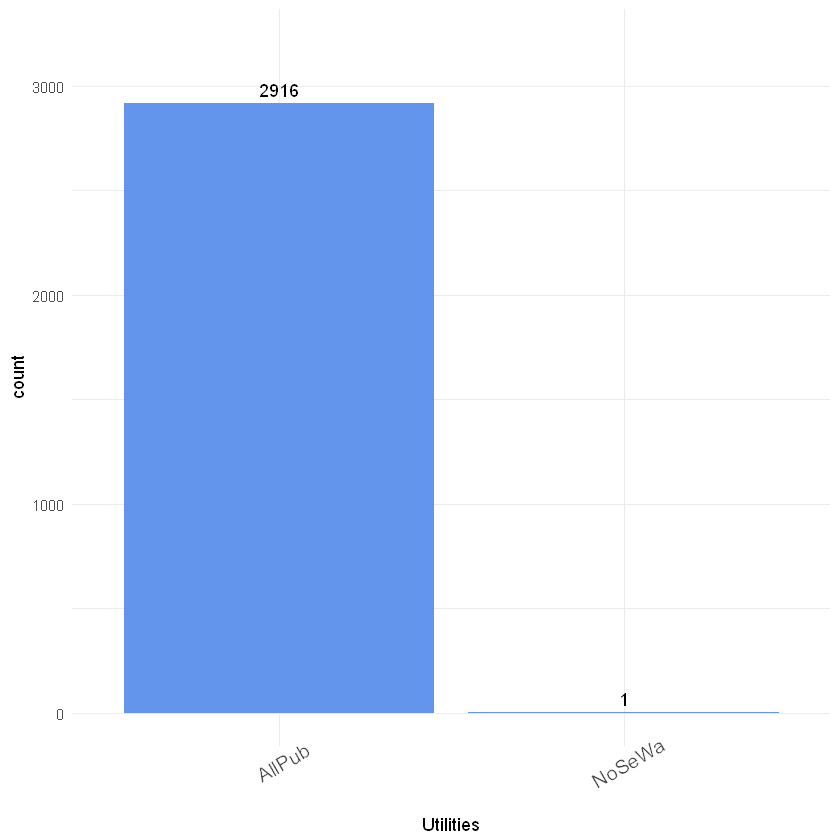

In [45]:
plot.categoric('Utilities', df.combined)

In [46]:
# Utilites 의 polt을 확인해본 결과, NoSsWa 는 1개의 값을 가지고 모두 AllPub임을 알 수 있다.
# 따라서 NoSeWa 의 1개 변수를 제거 
# 그럼 모든 값이 AllPub이므로 이는 예측 모델링에 도움이 안됨. --> utilities 가 집값에 주는 영향이 없다고 판단. 

# NoSeWa 피처 삭제
which(df.combined$Utilities == 'NoSeWa')
col.drops <- c('Utilities')
# utilites 변수 삭제
df.combined <- df.combined[,!names(df.combined) %in% c('Utilities')]

[1] 945

- ### MSZoning : The general zoing classification
- ### MSSubClass: The building class

In [48]:
df.combined[is.na(df.combined$MSZoning), c('MSZoning', 'MSSubClass')]

,MSZoning,MSSubClass
1916,NA,30
2217,NA,20
2251,NA,70
2905,NA,20


Warning message:
"Removed 4 rows containing non-finite values (stat_count)."Warning message:
"Removed 4 rows containing non-finite values (stat_count)."Warning message:
"Removed 4 rows containing non-finite values (stat_count)."

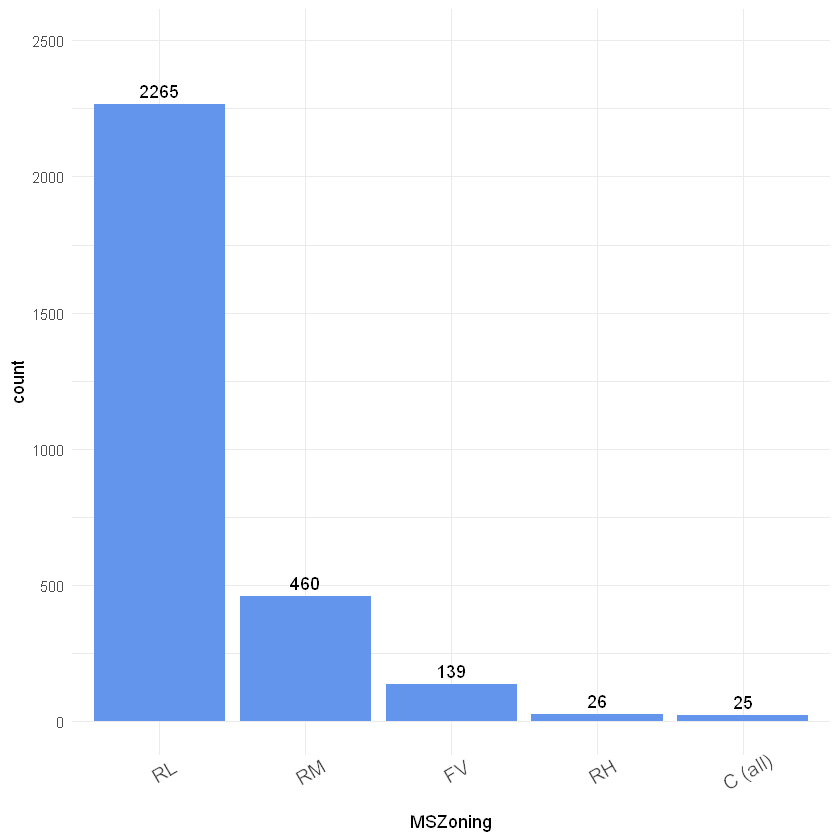

In [49]:
plot.categoric('MSZoning', df.combined)

In [51]:
# MSZoning 과 MSSubClass 관계확인
table(df.combined$MSZoning, df.combined$MSSubClass)

         
            20   30   40   45   50   60   70   75   80   85   90  120  150  160
  C (all)    3    8    0    0    7    0    4    0    0    0    0    0    0    0
  FV        34    0    0    0    0   43    0    0    0    0    0   19    0   43
  RH         4    2    0    1    2    0    3    0    0    0    4    6    0    0
  RL      1016   61    4    6  159  529   57    9  115   47   92  117    1   21
  RM        20   67    2   11  119    3   63   14    3    1   13   40    0   64
         
           180  190
  C (all)    0    3
  FV         0    0
  RH         0    4
  RL         0   31
  RM        17   23

In [52]:
# MSSubClass 와 비교하여 MSZoning 의 결측치 처리
df.combined$MSZoning[c(2217, 2905)] = 'RL'
df.combined$MSZoning[c(1916, 2251)] = 'RM'

- ### MasVnrType: Masonry veneer type(벽돌 베니어 타입)
    - 24 missing values
- ### MasVnrArea: Masonry veneer area in square feet
    - 23 missing values

In [53]:
df.combined[(is.na(df.combined$MasVnrType)) | (is.na(df.combined$MasVnrArea)), c('MasVnrType', 'MasVnrArea')]

,MasVnrType,MasVnrArea
235,NA,NA
530,NA,NA
651,NA,NA
937,NA,NA
974,NA,NA
978,NA,NA
1244,NA,NA
1279,NA,NA
1692,NA,NA
1707,NA,NA


In [67]:
# MasVnrType 범위에 따른 MasVnrArea의 중위값과 counts
# group_by(na.omit(MasVnrType))
cat(" *na.omit : object에 NA가 포함되어 있으면 이를 제외")
na.omit(df.combined[,c('MasVnrType','MasVnrArea')]) %>%
  group_by(na.omit(MasVnrType)) %>%
  summarise(MedianArea = median(MasVnrArea,na.rm = TRUE), counts = n()) %>%
  arrange(MedianArea)

 *na.omit : object에 NA가 포함되어 있으면 이를 제외

na.omit(MasVnrType),MedianArea,counts
None,0,1765
BrkCmn,161,25
Stone,200,249
BrkFace,203,880


In [60]:
df.combined[2611, 'MasVnrType'] = 'BrkFace'

In [62]:
# 두 변수의 결측치를 각각 None 과 0 으로 처리 --> 결측치 자체를 벽돌 베니어가 없다고 가정
df.combined$MasVnrType[is.na(df.combined$MasVnrType)] = 'None'
df.combined$MasVnrArea[is.na(df.combined$MasVnrArea)] = 0

- ### LotFrontage: Linear feet of street connected to property
    - 486 missing values
    - missing value를 다 0 으로 처리하지 못한다. --> neighborhood와 관련하여 결측값 처리

In [69]:
# Neighborhood 변수에 따른 LotFrontage 의 중앙값 

#df.combined['Nbrh.factor'] <- factor(df.combined$Neighborhood, levels = unique(df.combined$Neighborhood))
lot.by.nbrh <- df.combined[,c('Neighborhood','LotFrontage')] %>%
  group_by(Neighborhood) %>%
  summarise(median = median(LotFrontage, na.rm = TRUE))
lot.by.nbrh

# LotFrontage 의 결측값 index가져오기
# Neighborhood[index] 값의 중앙값(Lotfrontage)을 불러와 결측치 처리
idx = which(is.na(df.combined$LotFrontage))
for( i in idx){
    # 
    lot.median <- lot.by.nbrh[lot.by.nbrh == df.combined$Neighborhood[i], 'median']
    df.combined[i, 'LotFrontage'] <- lot.median[[1]]
}

Neighborhood,median
Blmngtn,43.0
Blueste,24.0
BrDale,21.0
BrkSide,51.0
ClearCr,80.5
CollgCr,70.0
Crawfor,70.0
Edwards,65.0
Gilbert,64.0
IDOTRR,60.0


- ### Fence: Fence quality
    - 2348 missing value
- ### MiscFeature 
    - 2814 missing value

Warning message:
"Removed 2348 rows containing non-finite values (stat_count)."Warning message:
"Removed 2348 rows containing non-finite values (stat_count)."Warning message:
"Removed 2348 rows containing non-finite values (stat_count)."

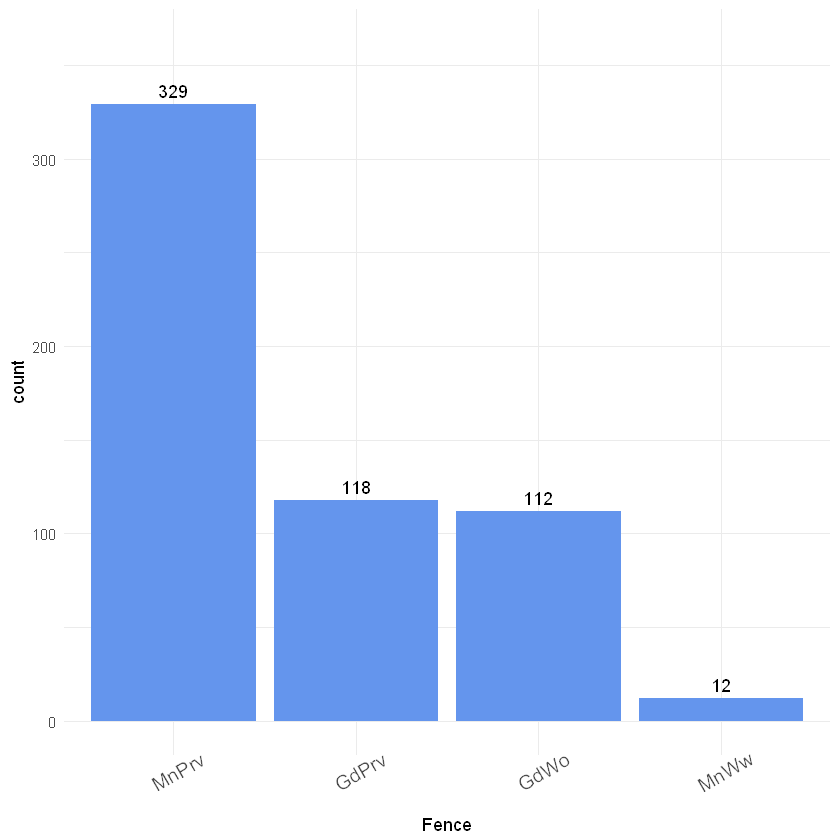

In [71]:
# fence 의 결측치 'none' 으로 처리
plot.categoric('Fence', df.combined)
df.combined$Fence[is.na(df.combined$Fence)] = 'None'

In [72]:
# miscFeature 결측치 'none'으로 처리
table(df.combined$MiscFeature)
df.combined$MiscFeature[is.na(df.combined$MiscFeature)] = 'None'


Gar2 Othr Shed TenC 
   5    4   95    1 

- ### Fireplaces: Number of fireplaces
- ### FireplaceQu: Fireplace quality
    - 1420 missing values

Warning message:
"Removed 1420 rows containing non-finite values (stat_count)."Warning message:
"Removed 1420 rows containing non-finite values (stat_count)."Warning message:
"Removed 1420 rows containing non-finite values (stat_count)."

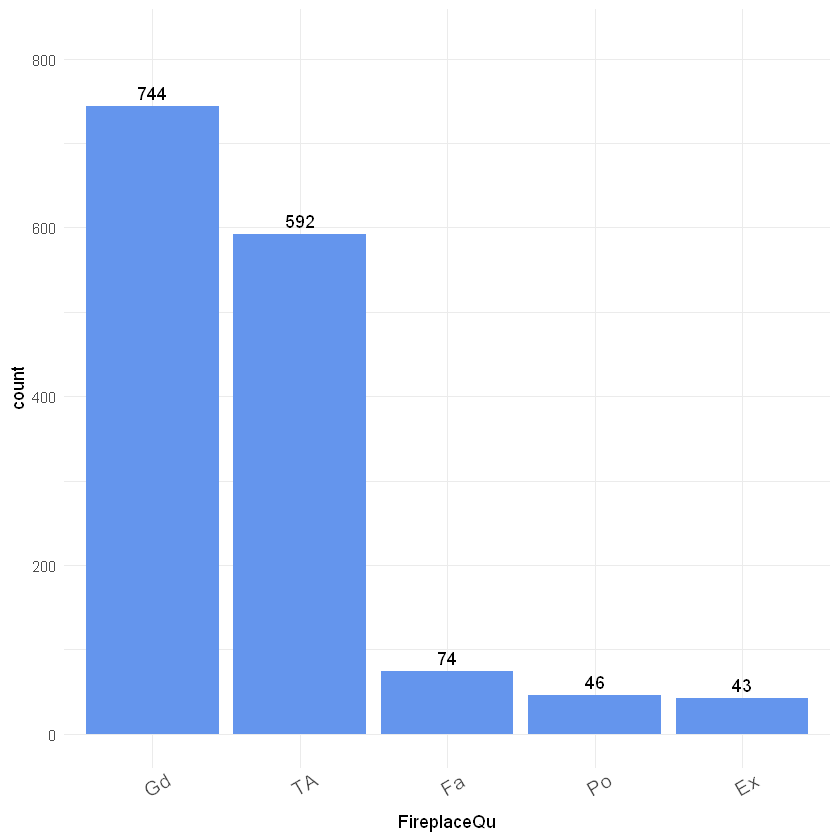

In [73]:
plot.categoric('FireplaceQu', df.combined)

In [76]:
# fireplace 가 1개 이상인 경우엔 fireplaceQu의 결측치가 없다 -> 벽난로가 없을 때, fireplaceQual 이 NA
which((df.combined$Fireplaces > 0) & (is.na(df.combined$FireplaceQu)))
df.combined$FireplaceQu[is.na(df.combined$FireplaceQu)] = 'None'

integer(0)

- ### Alley: Type of alley access (골목길의 종류)
    - 2721 missing values

Warning message:
"Removed 2721 rows containing non-finite values (stat_count)."Warning message:
"Removed 2721 rows containing non-finite values (stat_count)."Warning message:
"Removed 2721 rows containing non-finite values (stat_count)."

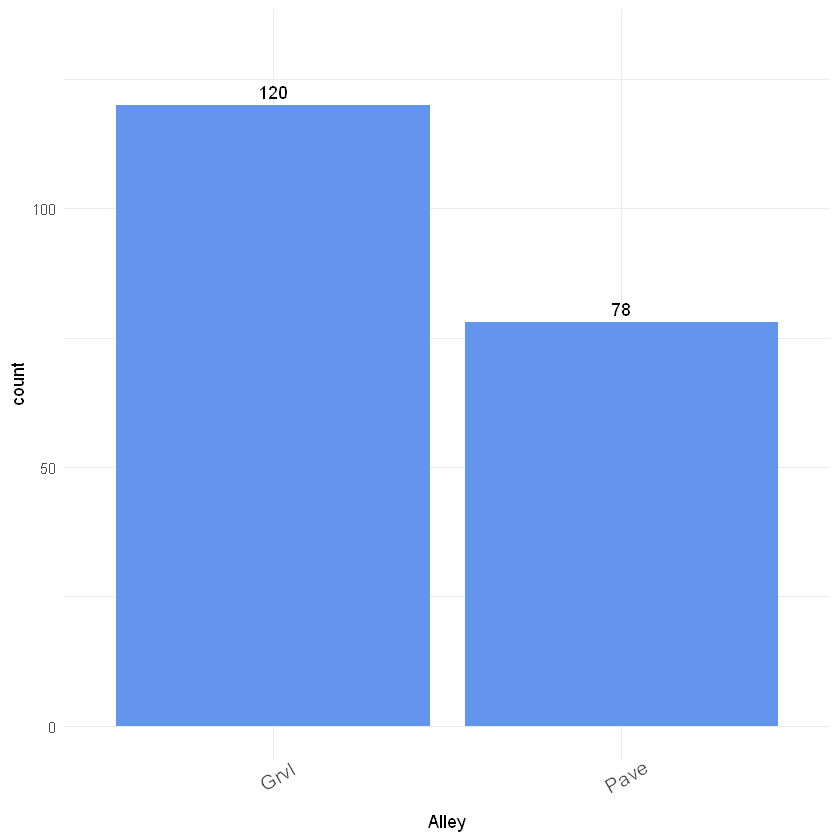

In [78]:
# 많은 결측치 -> alley 의 범주는 2개 , na 값은 alley 가없다라고 가정 -> 'none'
plot.categoric('Alley', df.combined)
df.combined$Alley[is.na(df.combined$Alley)] = 'None'

In [79]:
df.combined$Alley[is.na(df.combined$Alley)] = 'None'

In [80]:
# 결측치 처리 다했는지 확인
paste('There are', sum(sapply(df.combined, is.na)), 'missing values left')

[1] "There are 0 missing values left"

# Adding custom numeric features
    - data set -> numeric set + categoric set
    - 많은 정보를 유지하기 위해 numeric values로 변환
    - categoric --> one-hot encoding --> binary features

In [81]:
# data set을 2개로 나눔
num_features <- names(which(sapply(df.combined, is.numeric)))
cat_features <- names(which(sapply(df.combined, is.character)))

# numeric 변수들을 새로운 데이터 프레임으로 만듦
df.numeric <- df.combined[num_features]

In [83]:
# train data set을 따로 group.df
group.df <- df.combined[1:1460,]
group.df$SalePrice <- train$SalePrice

## Converting Categoric values to Numeric values Process

In [96]:
# ** 다시 확인할 것
# function that groups a column by its features and returns the mdedian saleprice for each unique feature. 
group.prices <- function(col) {
  group.table <- group.df[,c(col, 'SalePrice', 'OverallQual')] %>%
    group_by_(col) %>%
    summarise(mean.Quality = round(mean(OverallQual),2),
      mean.Price = mean(SalePrice), n = n()) %>%
    arrange(mean.Quality)
    
  print(qplot(x=reorder(group.table[[col]], -group.table[['mean.Price']]), y=group.table[['mean.Price']]) +
    geom_bar(stat='identity', fill='cornflowerblue') +
    theme_minimal() +
    scale_y_continuous(labels = dollar) +
    labs(x=col, y='Mean SalePrice') +
    theme(axis.text.x = element_text(angle = 45)))
  
  return(data.frame(group.table))
}

## functional to compute the mean overall quality for each quality
quality.mean <- function(col) {
  group.table <- df.combined[,c(col, 'OverallQual')] %>%
    group_by_(col) %>%
    summarise(mean.qual = mean(OverallQual)) %>%
    arrange(mean.qual)
  
  return(data.frame(group.table))
}


# function that maps a categoric value to its corresponding numeric value and returns that column to the data frame
map.fcn <- function(cols, map.list, df){
  for (col in cols){
    df[col] <- as.numeric(map.list[df.combined[,col]])
  }
  return(df)
}

In [97]:
# 컬럼명에 'Qual', ' Cond' 가 있는 컬럼 --> 특정 품질or 조건 --> 순서가 있다.
# Ex = 5, GD = 4, TA = 3, Fa = 2, Po = 1, None = 0 (categoric->numeric)

qual.cols <- c('ExterQual', 'ExterCond', 'GarageQual', 'GarageCond', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtQual')

- ### "FireplaceQu" 의 특징 및 SalePrice 간의 관계

FireplaceQu,mean.Quality,mean.Price,n
Po,4.95,129764.1,20
None,5.46,141331.5,690
Fa,5.76,167298.5,33
TA,6.48,205723.5,313
Gd,6.89,226351.4,380
Ex,8.38,337712.5,24


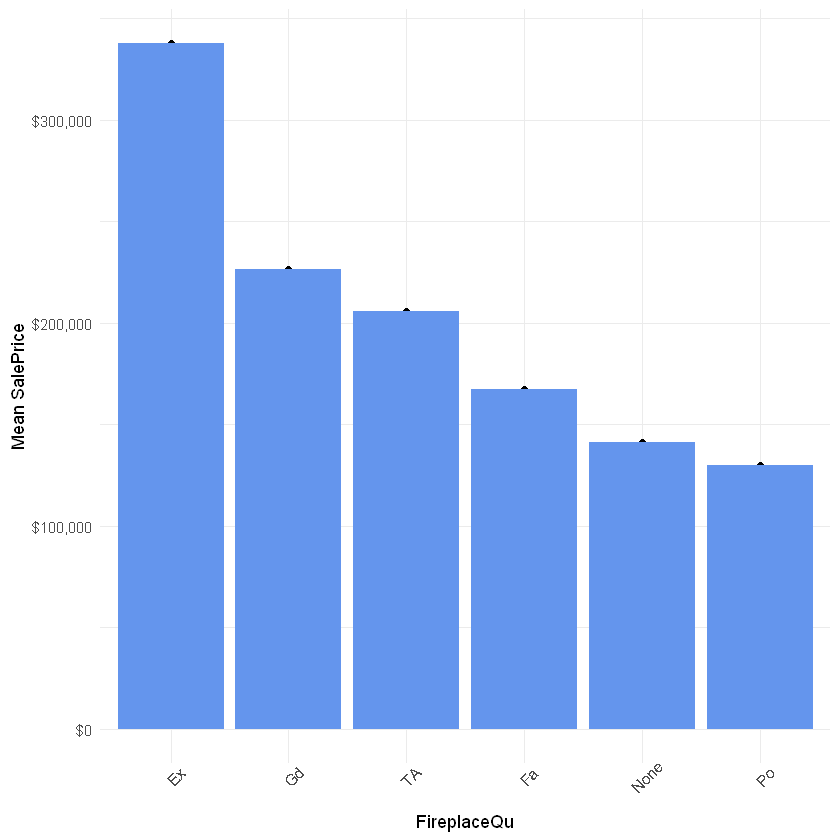

In [88]:
group.prices('FireplaceQu')

- ### "BsmtQual" 의 특징 및 SalePrice 간의 관계

BsmtQual,mean.Quality,mean.Price,n
None,4.30,105652.9,37
Fa,4.89,115692.0,35
TA,5.33,140759.8,649
Gd,6.66,202688.5,618
Ex,8.26,327041.0,121


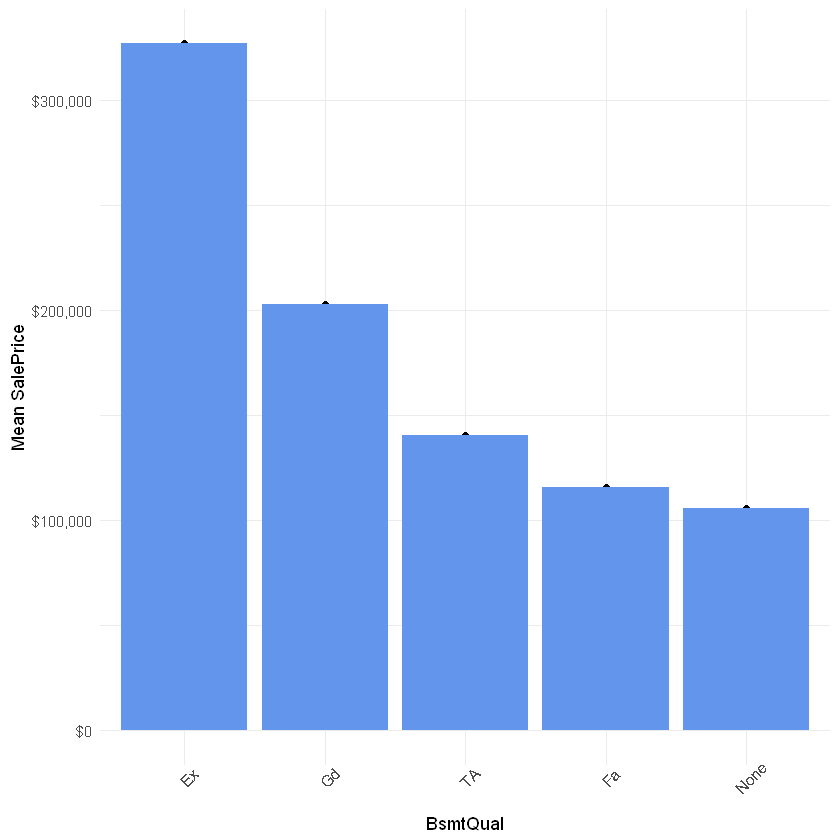

In [89]:
group.prices('BsmtQual')

- ### "KitchenQual" 의 특징 및 SalePrice 간의 관계

KitchenQual,mean.Quality,mean.Price,n
Fa,4.49,105565.2,39
TA,5.34,139962.5,735
Gd,6.79,212116.0,586
Ex,8.27,328554.7,100


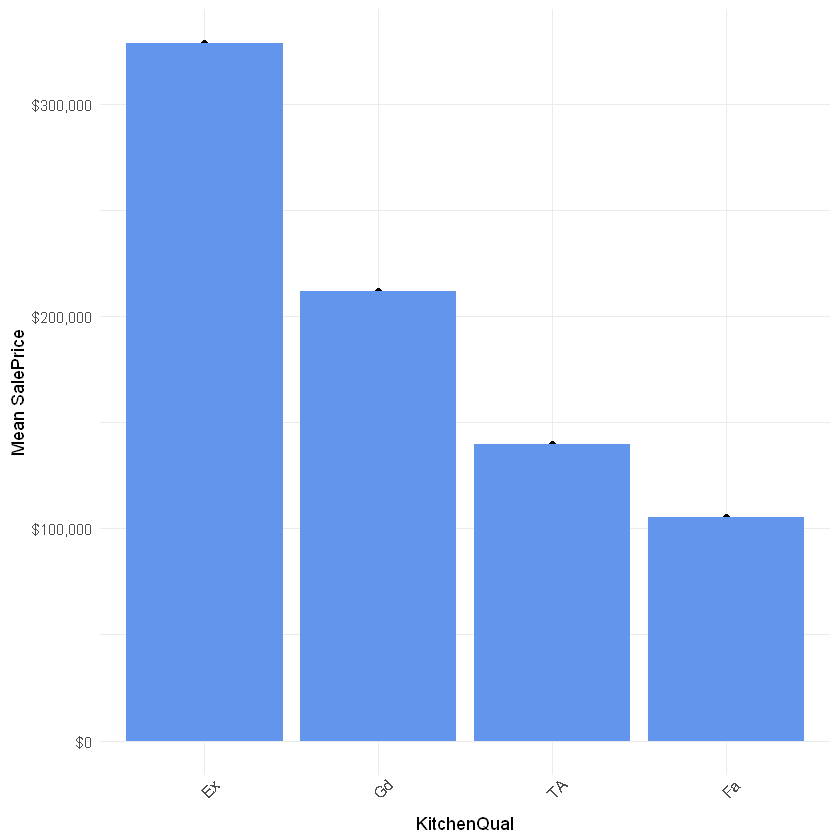

In [90]:
group.prices('KitchenQual')

In [93]:
# 품질/조건 이 있는 categoric 변수를 numeric으로 변환  
qual.list <- c('None' = 0, 'Po' = 1, 'Fa' = 2, 'TA' = 3, 'Gd' = 4, 'Ex' = 5)

# qual.cols : qual, cond 가 들어가 있는 변수 
# qual.list : 0~5 의 변환값
# df.numeric : categoric 에서 numeric으로 변환된 col을 numeric 변수들로 만들었던 df.numeric에 추가
df.numeric <- map.fcn(qual.cols, qual.list, df.numeric)

- ### "BsmtExposure" 의 특징 및 SalePrice 간의 관계

BsmtExposure,mean.Quality,mean.Price,n
None,4.30,105652.9,37
No,5.92,165680.4,954
Mn,6.25,192789.7,114
Av,6.57,206643.4,221
Gd,6.96,257689.8,134


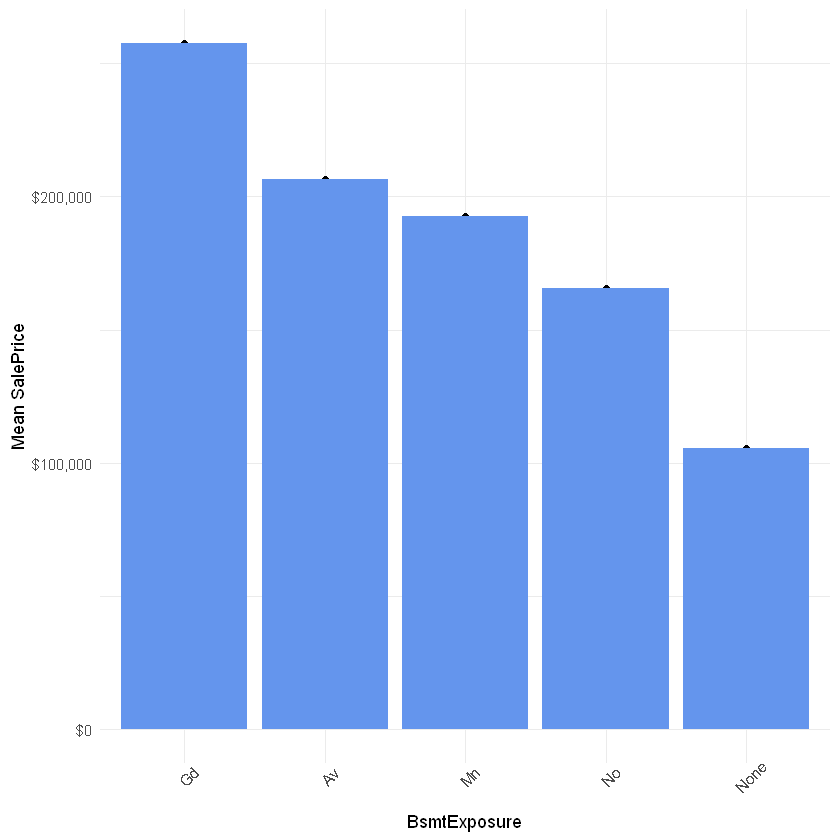

In [94]:
group.prices('BsmtExposure')

In [95]:
# bamtExposure도 qual/cond 와 마찬가지로 salePrice 와 관계를 파악하여 변환했음.
bsmt.list <- c('None' = 0, 'No' = 1, 'Mn' = 2, 'Av' = 3, 'Gd' = 4)
df.numeric = map.fcn(c('BsmtExposure'), bsmt.list, df.numeric)

- ### "BsmtFinType1" 의 특징 및 SalePrice 간의 관계
    - BsmtFinType1: Quality of basement finished area (지하실의 품질)
    - BsmtFinSF1: Type 1 finished square feet (지하실의 평수)

BsmtFinType1,mean.Quality,mean.Price,n
None,4.30,105652.9,37
BLQ,5.35,149493.7,148
Rec,5.35,146889.2,133
LwQ,5.54,151852.7,74
ALQ,5.55,161573.1,220
Unf,6.20,170670.6,430
GLQ,7.05,235413.7,418


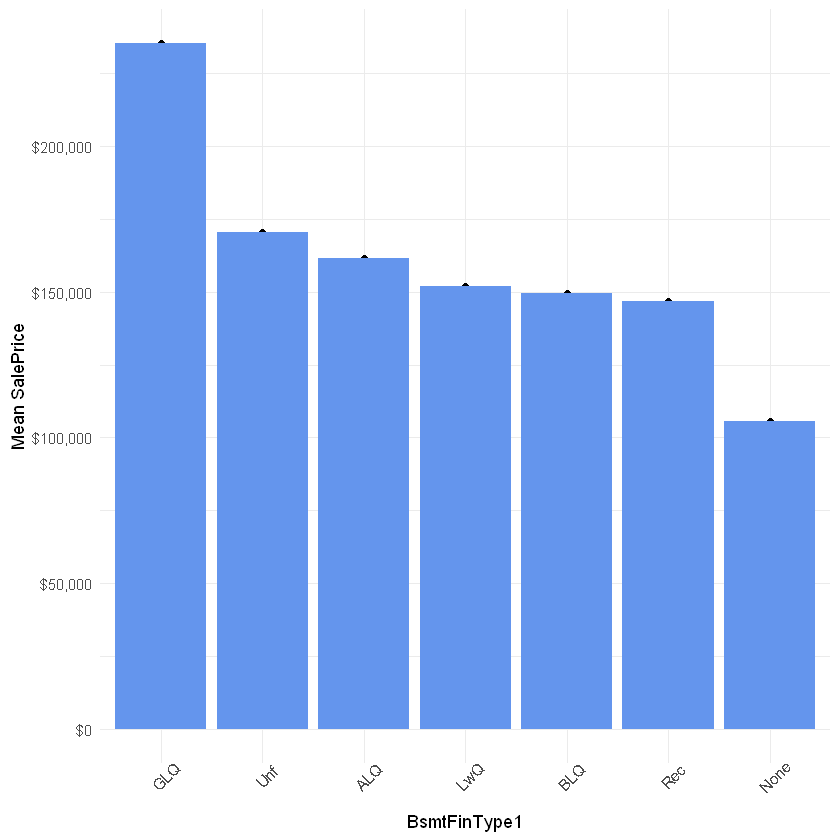

In [98]:
group.prices('BsmtFinType1')

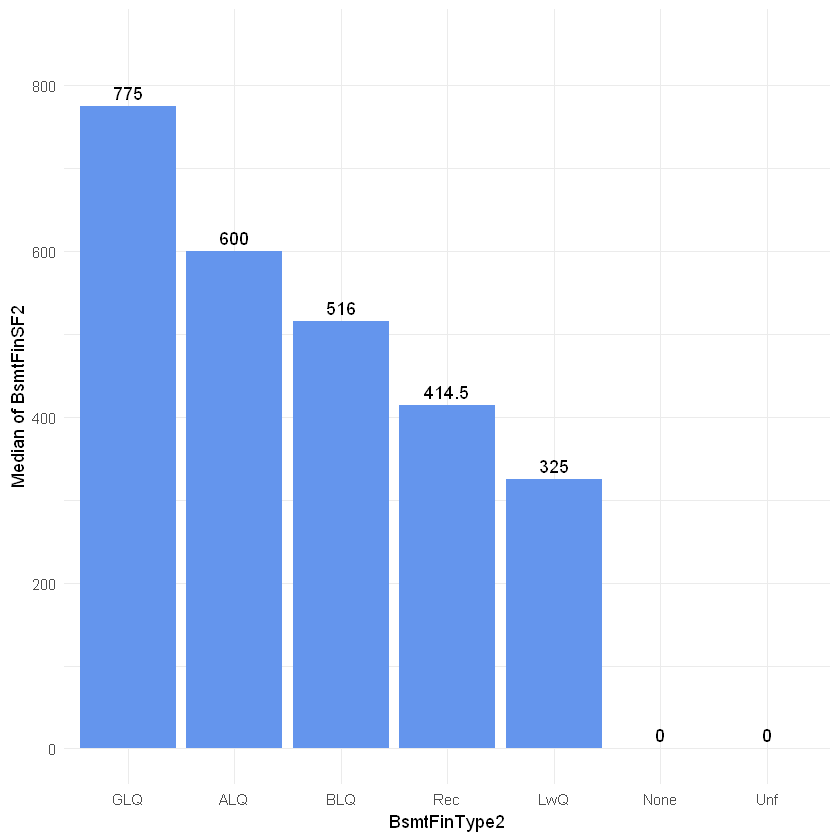

In [99]:
# 앞서 BsmtFinType1 과 평균 saleprice 간의 관계로는 각 범주를 판단하기 어려움
# 따라서 BsmtFinSF1 의 중앙값과의 관계로 파악하려함. 
df.combined[,c('BsmtFinType1', 'BsmtFinSF1')] %>%
  group_by(BsmtFinType1) %>%
  summarise(medianArea = median(BsmtFinSF1), counts = n()) %>%
  arrange(medianArea) %>%
  ggplot(aes(x=reorder(BsmtFinType1,-medianArea), y=medianArea)) +
  geom_bar(stat = 'identity', fill='cornflowerblue') +
  labs(x='BsmtFinType2', y='Median of BsmtFinSF2') +
  geom_text(aes(label = sort(medianArea)), vjust = -0.5) +
  scale_y_continuous(limits = c(0,850)) +
  theme_minimal()

In [101]:
# 위의 결과를 바탕으로 순서가 있는 numeric으로 변환한 후 df.numeric 데이터 셋에 추가
#‘None’ < ‘Unf’ < ‘LwQ’ < ‘BLQ’ < ‘Rec’ < ‘ALQ’ < ‘GLQ’.
bsmt.fin.list <- c('None' = 0, 'Unf' = 1, 'LwQ' = 2,'Rec'= 3, 'BLQ' = 4, 'ALQ' = 5, 'GLQ' = 6)
df.numeric <- map.fcn(c('BsmtFinType1','BsmtFinType2'), bsmt.fin.list, df.numeric)

- ### "Functional" 의 특징 및 SalePrice 간의 관계
    - 다른 변수와의 관계로 파악하기 어려운 변수 --> saleprice로 판단

Functional,mean.Quality,mean.Price,n
Min2,4.97,144240.6,34
Maj2,5.00,85800.0,5
Min1,5.26,146385.5,31
Mod,5.40,168393.3,15
Maj1,5.50,153948.1,14
Sev,6.00,129000.0,1
Typ,6.16,183429.1,1360


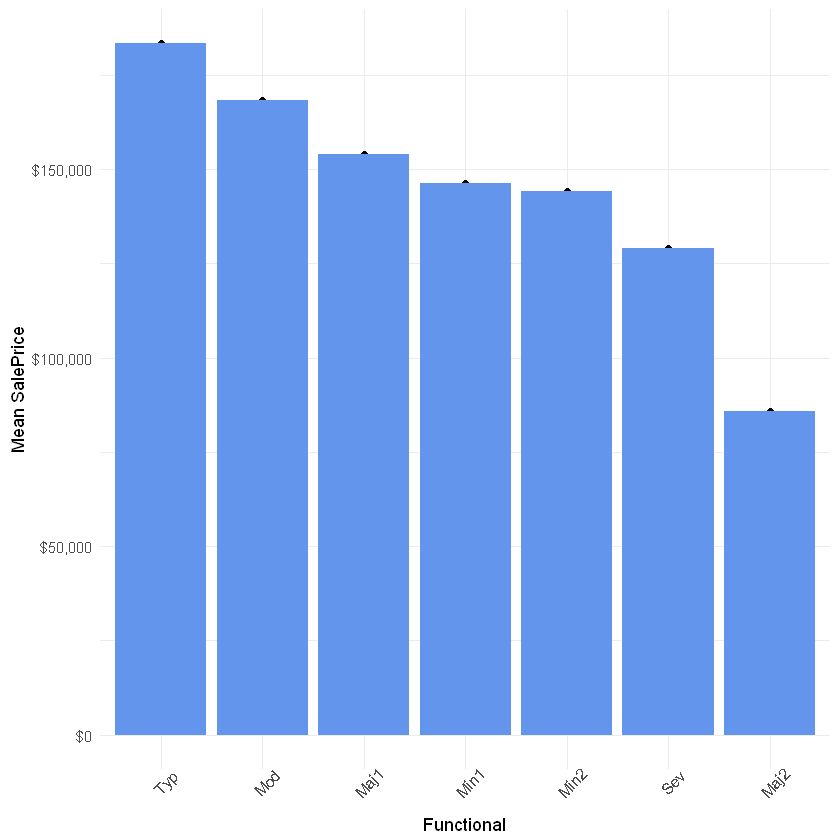

In [102]:
group.prices('Functional')

In [103]:
functional.list <- c('None' = 0, 'Sal' = 1, 'Sev' = 2, 'Maj2' = 3, 'Maj1' = 4, 'Mod' = 5, 'Min2' = 6, 'Min1' = 7, 'Typ'= 8)

df.numeric['Functional'] <- as.numeric(functional.list[df.combined$Functional])

- ### "GarageFinish" 의 특징 및 SalePrice 간의 관계

GarageFinish,mean.Quality,mean.Price,n
None,4.60,103317.3,81
Unf,5.40,142156.4,605
RFn,6.57,202068.9,422
Fin,7.07,240052.7,352


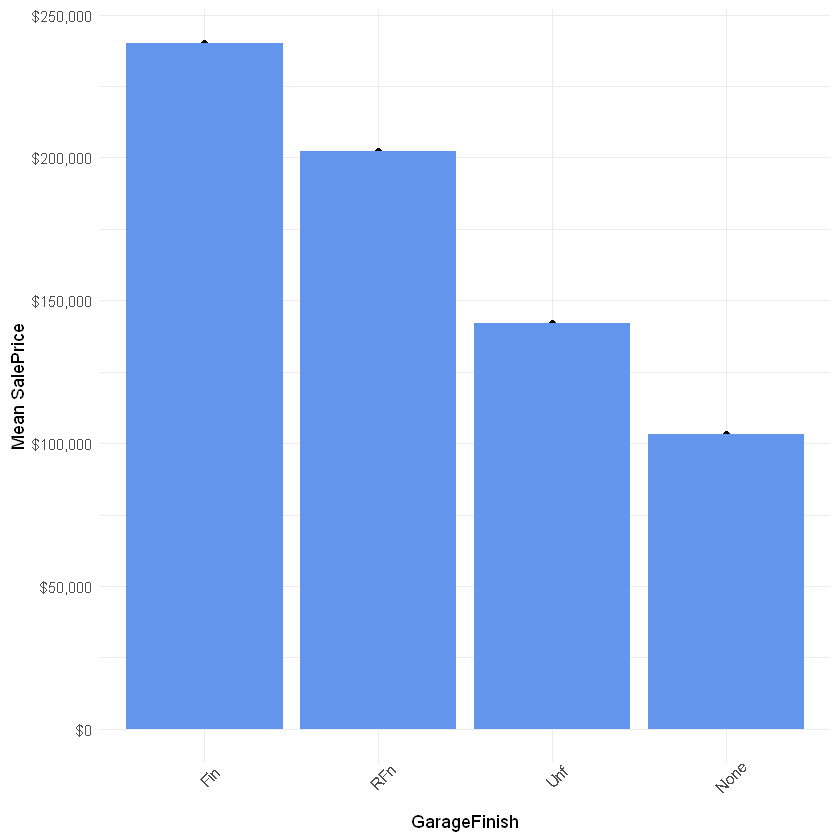

In [104]:
group.prices('GarageFinish')

In [105]:
garage.fin.list <- c('None' = 0,'Unf' = 1, 'RFn' = 1, 'Fin' = 2)

df.numeric['GarageFinish'] <- as.numeric(garage.fin.list[df.combined$GarageFinish])

- ### "Fence" 의 특징 및 SalePrice 간의 관계

Fence,mean.Quality,mean.Price,n
GdWo,5.17,140379.3,54
MnWw,5.18,134286.4,11
MnPrv,5.45,148751.1,157
None,6.23,187596.8,1179
GdPrv,6.31,178927.5,59


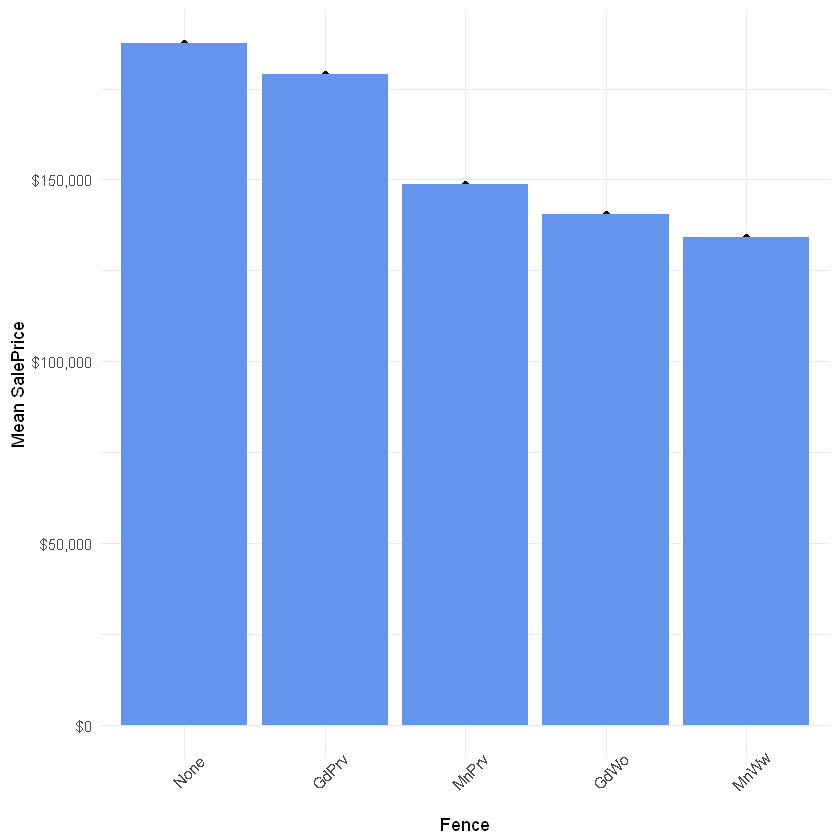

In [106]:
group.prices('Fence')

In [107]:
fence.list <- c('None' = 0, 'MnWw' = 1, 'GdWo' = 1, 'MnPrv' = 2, 'GdPrv' = 4)

df.numeric['Fence'] <- as.numeric(fence.list[df.combined$Fence])

- ### "MSSubClass" -> "NewerDwelling"
    - MSSubClass 를 character화 --> MSdwelling.list로 numeric 화 --> df.numeric에 'NewerDwelling' 으로 추가

In [108]:
MSdwelling.list <- c('20' = 1, '30'= 0, '40' = 0, '45' = 0,'50' = 0, '60' = 1, '70' = 0, '75' = 0, '80' = 0, '85' = 0, '90' = 0, '120' = 1, '150' = 0, '160' = 0, '180' = 0, '190' = 0)

df.numeric['NewerDwelling'] <- as.numeric(MSdwelling.list[as.character(df.combined$MSSubClass)])

## 변환된 numeric 변수들과 salePrice 에 영향력을 많이 주는 변수를 찾아낼것 ( 상관계수 이용 )

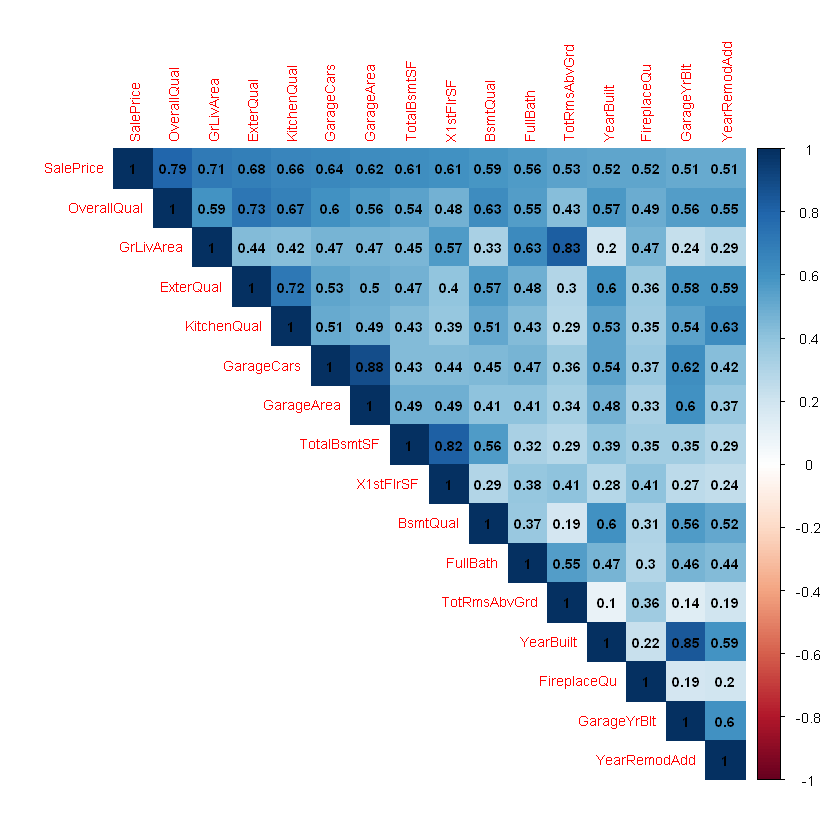

In [109]:
# salePrice col추가
corr.df <- cbind(df.numeric[1:1460,], train['SalePrice'])
# 변수들간의 상관관계
correlations <- cor(corr.df)
#SalePrice 와 강한 상관계수를 보이는 col이 궁금함. 내림차순으로
corr.SalePrice <- as.matrix(sort(correlations[,'SalePrice'], decreasing = TRUE))
# 
corr.idx <- names(which(apply(corr.SalePrice, 1, function(x) (x > 0.5 | x < -0.5))))

corrplot(as.matrix(correlations[corr.idx,corr.idx]), type = 'upper', method='color', addCoef.col = 'black', tl.cex = .7,cl.cex = .7, number.cex=.7)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 1.985"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.015"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  6.2259e-015"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4.0602"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 1.985"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.015"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) obje

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 5.025"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.025"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  9.4237e-015"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 5.025"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.025"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x 

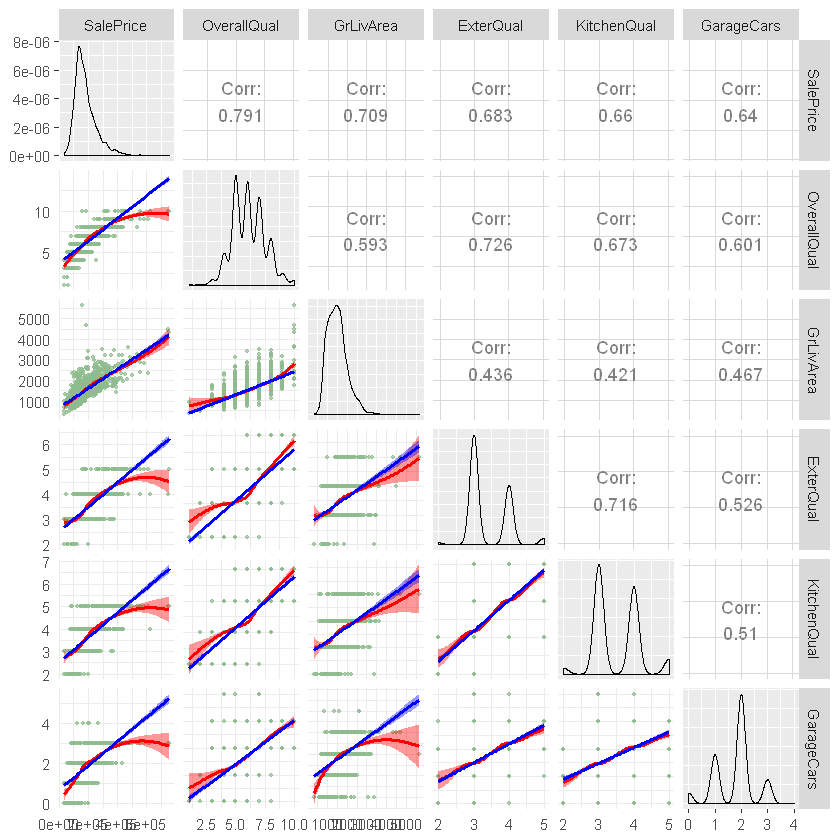

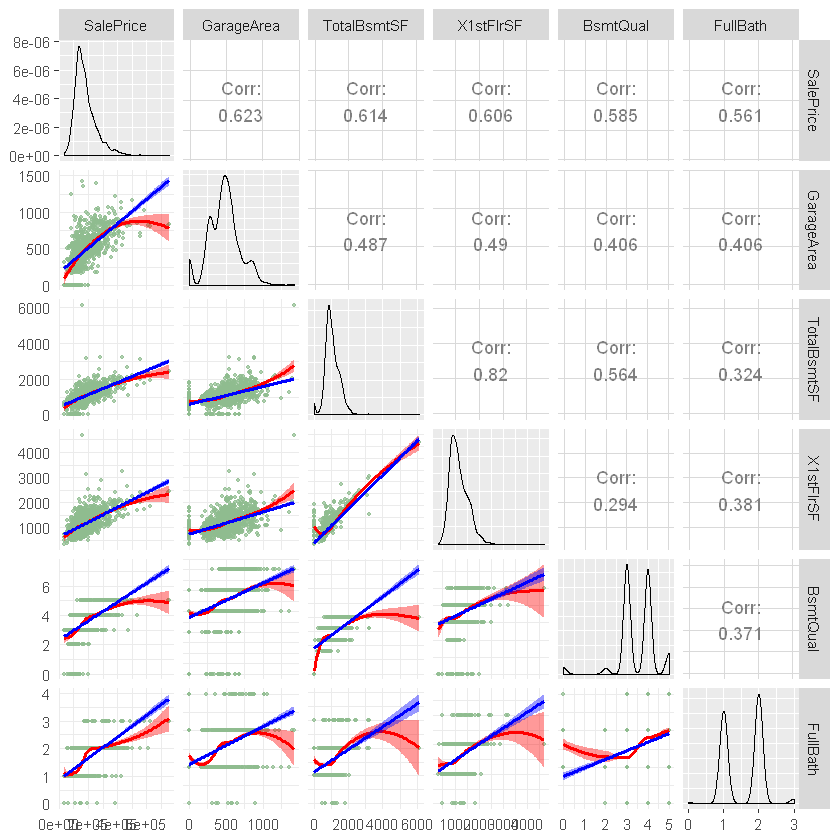

In [114]:
# GGally 패키지를 이용하여 앞서 나왔던 상위10개의 상관관계를 다시 분석
# GGally 설치시 오류 발생
# 해결방법) R에서 library(devtools)
#install_github("ggobi/ggally")

require(GGally)
lm.plt <- function(data, mapping, ...){
   plt <- ggplot(data = data, mapping = mapping) + 
    geom_point(shape = 20, alpha = 0.7, color = 'darkseagreen') +
    geom_smooth(method=loess, fill="red", color="red") +
    geom_smooth(method=lm, fill="blue", color="blue") +
    theme_minimal()
  return(plt)
}
# 1:6
ggpairs(corr.df, corr.idx[1:6], lower = list(continuous = lm.plt))
# 7:11
ggpairs(corr.df, corr.idx[c(1,7:11)], lower = list(continuous = lm.plt))

### nominal(명목형) 변수에서 특정값(최빈값)에 포함되면 1, 아니면 0으로 Binaray feature로 만들어준다. --> One-hot Encoding

- ### LotShape 
    - LandContour: Flatness of the property
    - LandSlope: Slope of property
    - Electrical: Electrical system
    - GarageType: Garage location
    - PavedDrive: Paved driveway
    - MiscFeature: Miscellaneous feature not covered in other categories

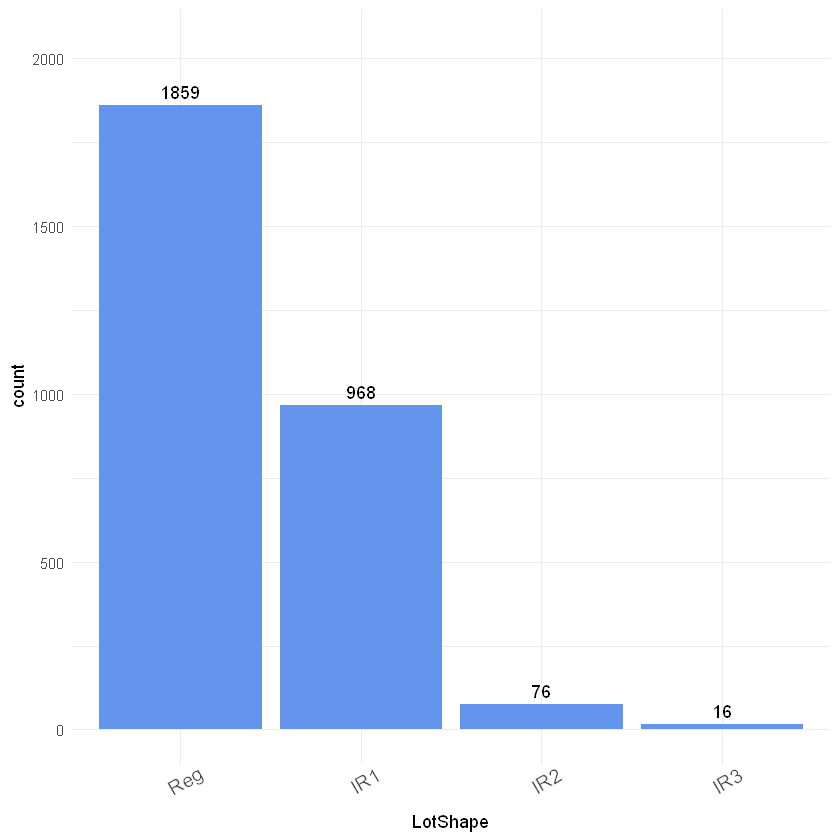

In [115]:
plot.categoric('LotShape', df.combined)

In [116]:
# LotShape : 1개의 Regular shape과 3개의 Irregular shape
df.numeric['RegularLotShape'] <- (df.combined$LotShape == 'Reg') * 1

In [117]:
# LotShape 와 같은 방법 적용
df.numeric['LandLeveled'] <- (df.combined$LandContour == 'Lvl') * 1
df.numeric['LandSlopeGentle'] <- (df.combined$LandSlope == 'Gtl') * 1
df.numeric['ElectricalSB'] <- (df.combined$Electrical == 'SBrkr') * 1
df.numeric['GarageDetchd'] <- (df.combined$GarageType == 'Detchd') * 1
df.numeric['HasPavedDrive'] <- (df.combined$PavedDrive == 'Y') * 1
df.numeric['HasWoodDeck'] <- (df.combined$WoodDeckSF > 0) * 1
df.numeric['Has2ndFlr'] <- (df.combined$X2ndFlrSF > 0) * 1
df.numeric['HasMasVnr'] <- (df.combined$MasVnrArea > 0) * 1
df.numeric['HasShed'] <- (df.combined$MiscFeature == 'Shed') * 1

- ### YearBuilt: Original construction date
- ### YearRemodAdd: Remodel date

In [118]:
# 거의 대부분 YearBlt 와 YearRemodAdd 가 같음 --> remodeling 을 안했단 얘기
# 다를 경우 Remodeled 된 것으로 판단하여 리모델링 했는지 안했는지 더미 변수 생성
df.numeric['Remodeled'] <- (df.combined$YearBuilt != df.combined$YearRemodAdd) * 1

In [119]:
# Remodeling 된 집 중에서도 최근에 했는지에 따른 더미 변수 생성
# 기준 : 판매 된 해 이후에 리모델링 된 주택은 1, 아니면 0
df.numeric['RecentRemodel'] <- (df.combined$YearRemodAdd >= df.combined$YrSold) * 1

In [120]:
# 지어진 날짜(YearBlt)와 판매된 날짜(YearSold)가 같으면 --> 인기있는 집이라고 (잠재적)가정
df.numeric['NewHouse'] <- (df.combined$YearBuilt == df.combined$YrSold) * 1

### house area에 관하여 
    - feature가 0 인 경우      --> 0
    - feature 가 0 이상인 경우 --> 1

In [121]:
cols.binary <- c('X2ndFlrSF', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch')
for (col in cols.binary){
  df.numeric[str_c('Has',col)] <- (df.combined[,col] != 0) * 1
}

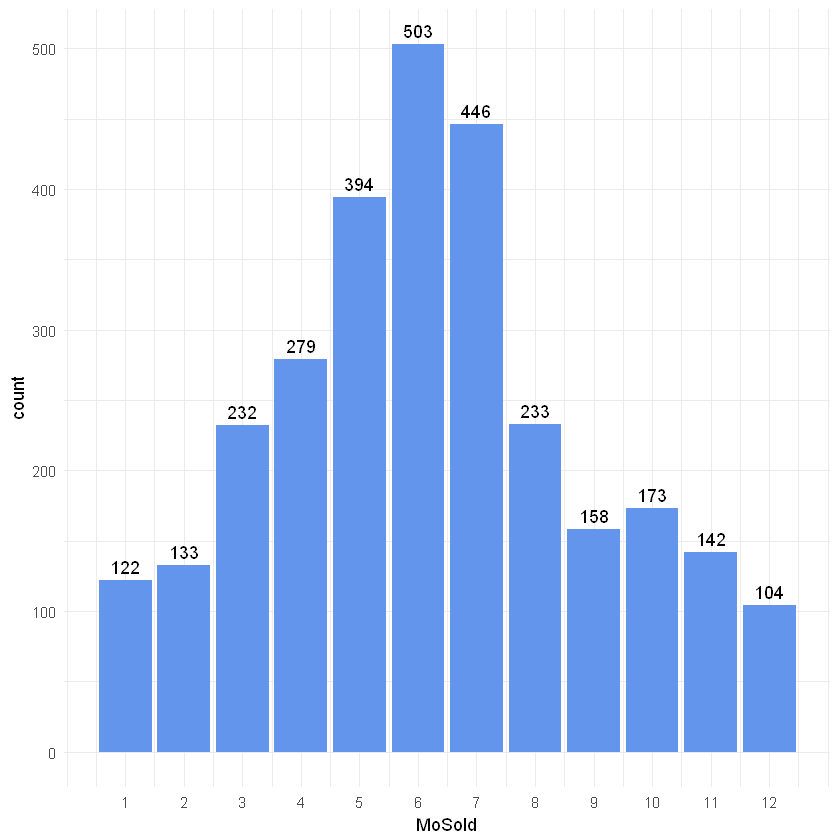

In [122]:
# 판매된 month 에 관한 ggplot
ggplot(df.combined, aes(x=MoSold)) +
  geom_bar(fill = 'cornflowerblue') +
  geom_text(aes(label=..count..), stat='count', vjust = -.5) +
  theme_minimal() +
  scale_x_continuous(breaks = 1:12)

In [123]:
# ggplot 으로 확인한 결과, 여름 시즌에 판매율이 높음(5월,)6월,7월 --> HighSeanson으로 더미 변수 생성
df.numeric['HighSeason'] <- (df.combined$MoSold %in% c(5,6,7)) * 1

## Neighborhoods 

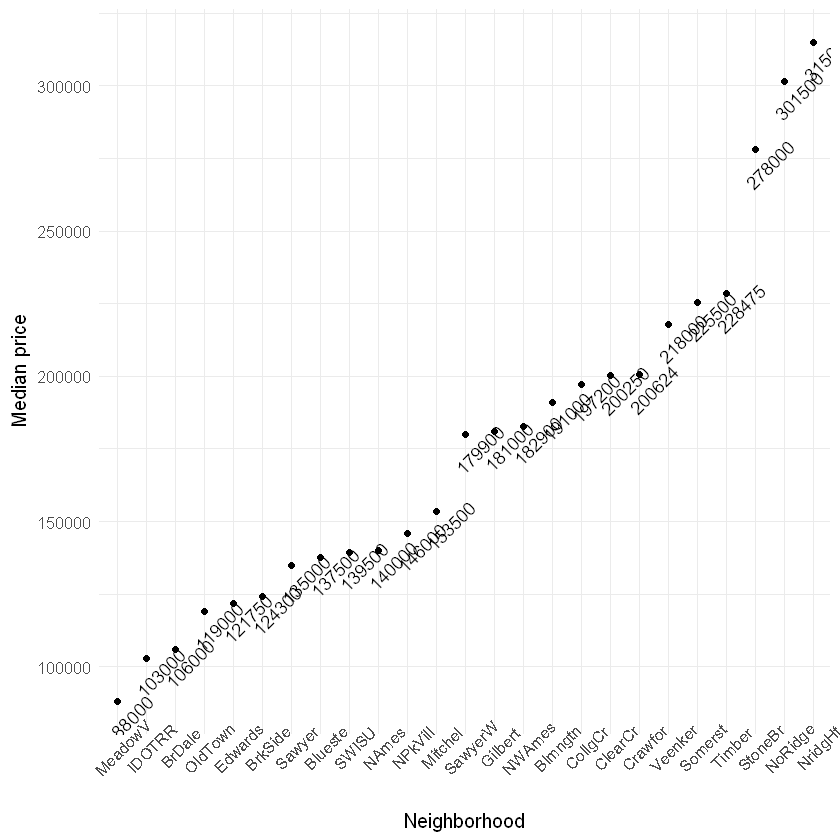

In [124]:
#neighborhoods 와 saleprice간의 관계
train[,c('Neighborhood','SalePrice')] %>%
  group_by(Neighborhood) %>%
  summarise(median.price = median(SalePrice, na.rm = TRUE)) %>%
  arrange(median.price) %>%
  mutate(nhbr.sorted = factor(Neighborhood, levels=Neighborhood)) %>%
  ggplot(aes(x=nhbr.sorted, y=median.price)) +
  geom_point() +
  geom_text(aes(label = median.price, angle = 45), vjust = 2) +
  theme_minimal() +
  labs(x='Neighborhood', y='Median price') +
  theme(text = element_text(size=12),
        axis.text.x = element_text(angle=45))

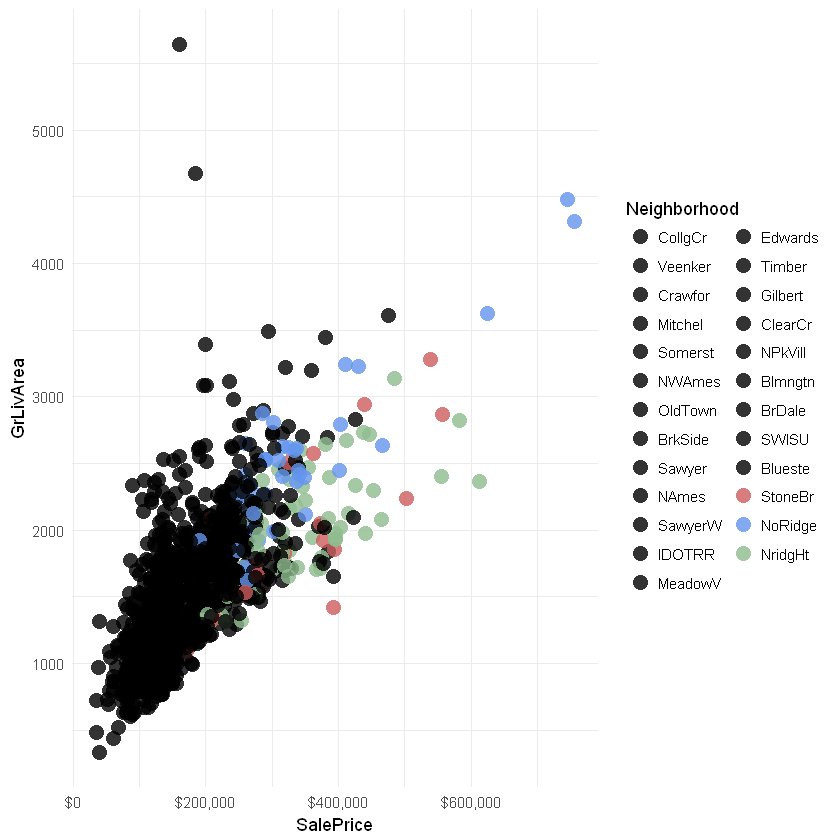

In [125]:
# 확인결과 ) StoneBr, NoRidge, NridgHt 가 가장 높음 
# 그러나, 이곳에서 이상치인지 아닌지 확인할 필요가 있음 --> 이상치 x

other.nbrh <- unique(df.combined$Neighborhood)[!unique(df.combined$Neighborhood) %in% c('StoneBr', 'NoRidge','NridgHt')]

ggplot(train, aes(x=SalePrice, y=GrLivArea, colour=Neighborhood)) +
  geom_point(shape=16, alpha=.8, size=4) +
  scale_color_manual(limits = c(other.nbrh, 'StoneBr', 'NoRidge', 'NridgHt'), values = c(rep('black', length(other.nbrh)), 'indianred',
                                    'cornflowerblue', 'darkseagreen')) +
  theme_minimal() +
  scale_x_continuous(label=dollar)

In [126]:
# neighborhood 상위 값 3개에서 --> 6개로 늘려서 새변수 설정
# rich -> 1 / others -> 0
nbrh.rich <- c('Crawfor', 'Somerst, Timber', 'StoneBr', 'NoRidge', 'NridgeHt')
df.numeric['NbrhRich'] <- (df.combined$Neighborhood %in% nbrh.rich) *1

Neighborhood,mean.Quality,mean.Price,n
MeadowV,4.47,98576.47,17
IDOTRR,4.76,100123.78,37
Sawyer,5.03,136793.14,74
BrkSide,5.05,124834.05,58
Edwards,5.08,128219.70,100
NAmes,5.36,145847.08,225
OldTown,5.39,128225.30,113
SWISU,5.44,142591.36,25
Mitchel,5.59,156270.12,49
BrDale,5.69,104493.75,16


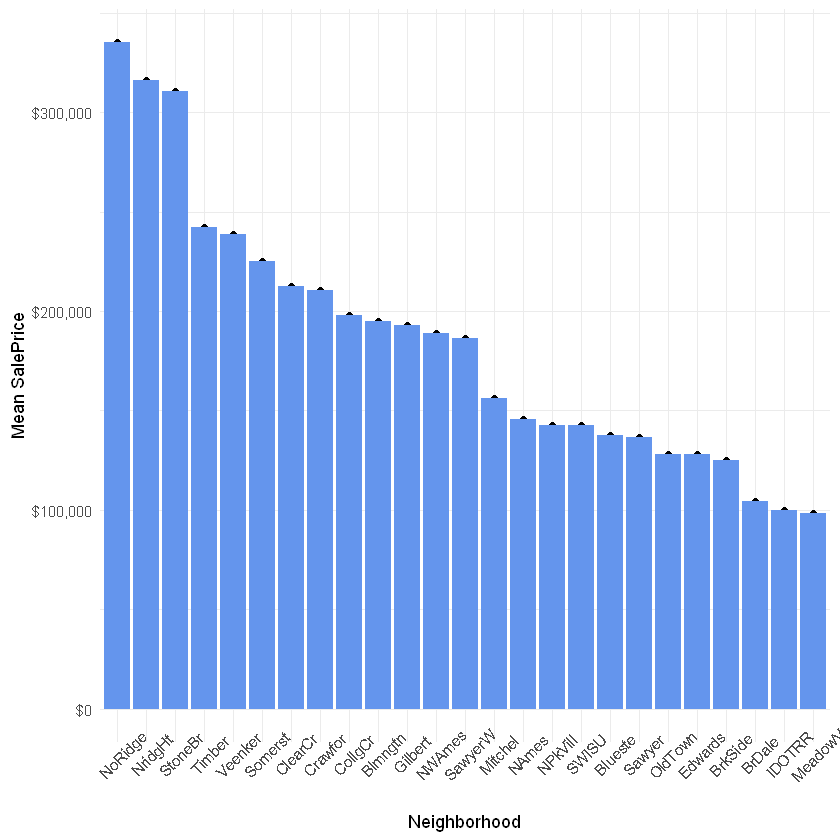

In [127]:
# 더 높은 품질의 더 높은 판매가격
# categoric to numeric --> NeighorhoodBin으로
group.prices('Neighborhood')

In [128]:
nbrh.map <- c('MeadowV' = 0, 'IDOTRR' = 1, 'Sawyer' = 1, 'BrDale' = 1, 'OldTown' = 1, 'Edwards' = 1, 
             'BrkSide' = 1, 'Blueste' = 1, 'SWISU' = 2, 'NAmes' = 2, 'NPkVill' = 2, 'Mitchel' = 2,
             'SawyerW' = 2, 'Gilbert' = 2, 'NWAmes' = 2, 'Blmngtn' = 2, 'CollgCr' = 2, 'ClearCr' = 3, 
             'Crawfor' = 3, 'Veenker' = 3, 'Somerst' = 3, 'Timber' = 3, 'StoneBr' = 4, 'NoRidge' = 4, 
             'NridgHt' = 4)

df.numeric['NeighborhoodBin'] <- as.numeric(nbrh.map[df.combined$Neighborhood])

### SaleCondition 

SaleCondition,mean.Quality,mean.Price,n
AdjLand,5.00,104125.0,4
Alloca,5.42,167377.4,12
Abnorml,5.57,146526.6,101
Family,5.80,149600.0,20
Normal,6.01,175202.2,1198
Partial,7.56,272291.8,125


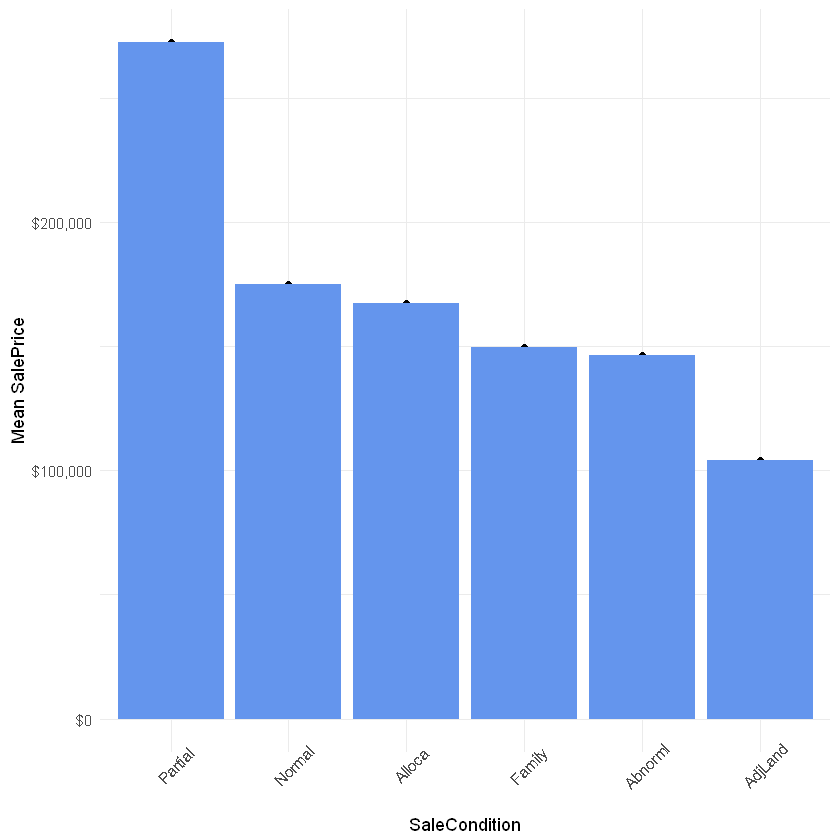

In [129]:
group.prices('SaleCondition')

In [130]:
# partial ->1 / others -> 0
df.numeric['PartialPlan'] <- (df.combined$SaleCondition == 'Partial') * 1

### HeatingQC

HeatingQC,mean.Quality,mean.Price,n
Fa,5.00,123919.5,49
Po,5.00,87000.0,1
TA,5.37,142362.9,428
Gd,5.70,156858.9,241
Ex,6.72,214914.4,741


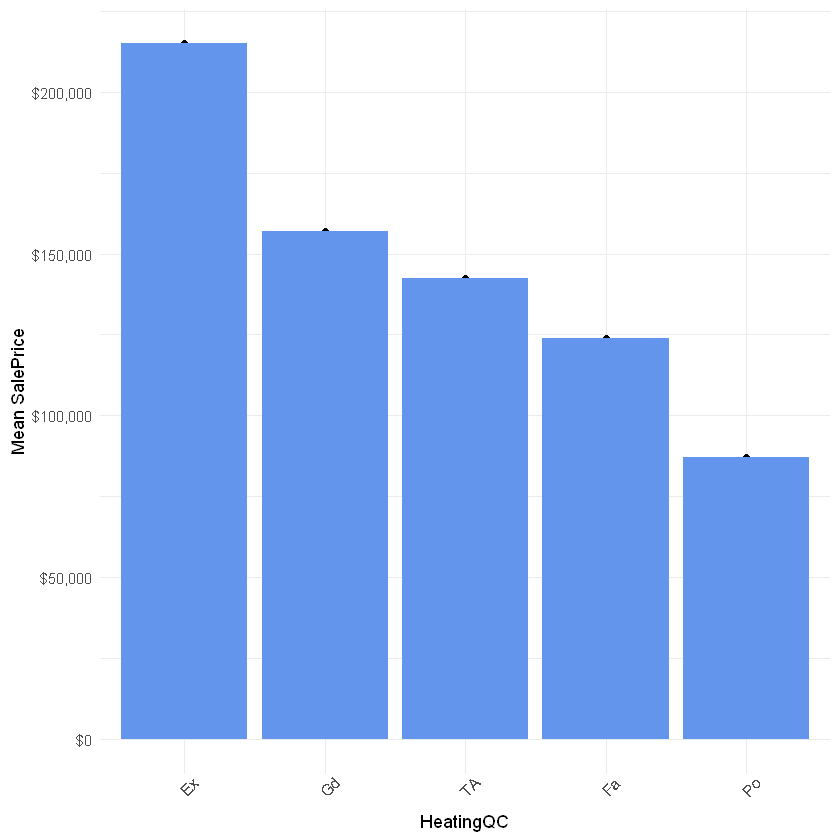

In [131]:
group.prices('HeatingQC')

In [132]:
# numeric 화
heating.list <- c('Po' = 0, 'Fa' = 1, 'TA' = 2, 'Gd' = 3, 'Ex' = 4)

df.numeric['HeatingScale'] <- as.numeric(heating.list[df.combined$HeatingQC])

## Area 에 관한 변수

In [133]:
# Total area
area.cols <- c('LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'TotalBsmtSF', 'X1stFlrSF', 'X2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
             'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea')

df.numeric['TotalArea'] <- as.numeric(rowSums(df.combined[,area.cols]))

# Area Inside ( 집 내부 영역)
df.numeric['AreaInside'] <- as.numeric(df.combined$X1stFlrSF + df.combined$X2ndFlrSF)

## 집의 연식 관련한 더미변수들

In [134]:
# 데이터가 2010 년 이전의 작성된 데이터이기때문에 2010 년 기준으로 집의 연식 계산
df.numeric['Age'] <- as.numeric(2010 - df.combined$YearBuilt)
# 2010 - 판매된 년도
df.numeric['TimeSinceSold'] <- as.numeric(2010 - df.combined$YrSold)
# 리모델링 된 후 판매 년도와의 관계
df.numeric['YearSinceRemodel'] <- as.numeric(df.combined$YrSold - df.combined$YearRemodAdd)

## OverallQual 과의 상관관계

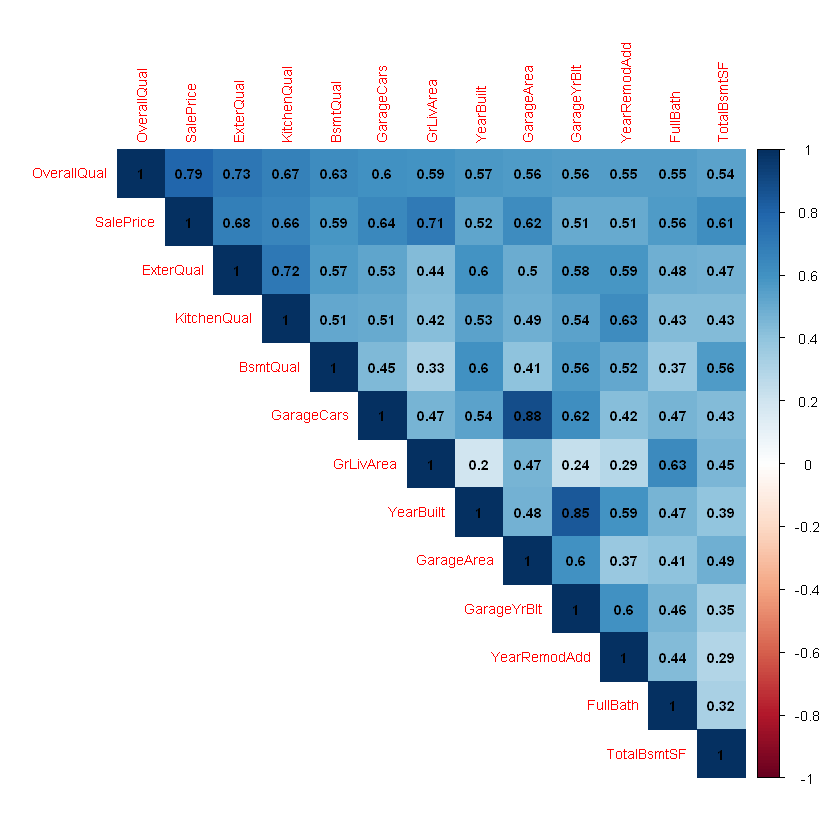

In [135]:
corr.OverallQual <- as.matrix(sort(correlations[,'OverallQual'], decreasing = TRUE))

corr.idx <- names(which(apply(corr.OverallQual, 1, function(x) (x > 0.5 | x < -0.5))))

corrplot(as.matrix(correlations[corr.idx, corr.idx]), type = 'upper',
         method = 'color', addCoef.col = 'black', tl.cex =.7, cl.cex = .7,
         number.cex = .7)

# Outliers 이상치

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


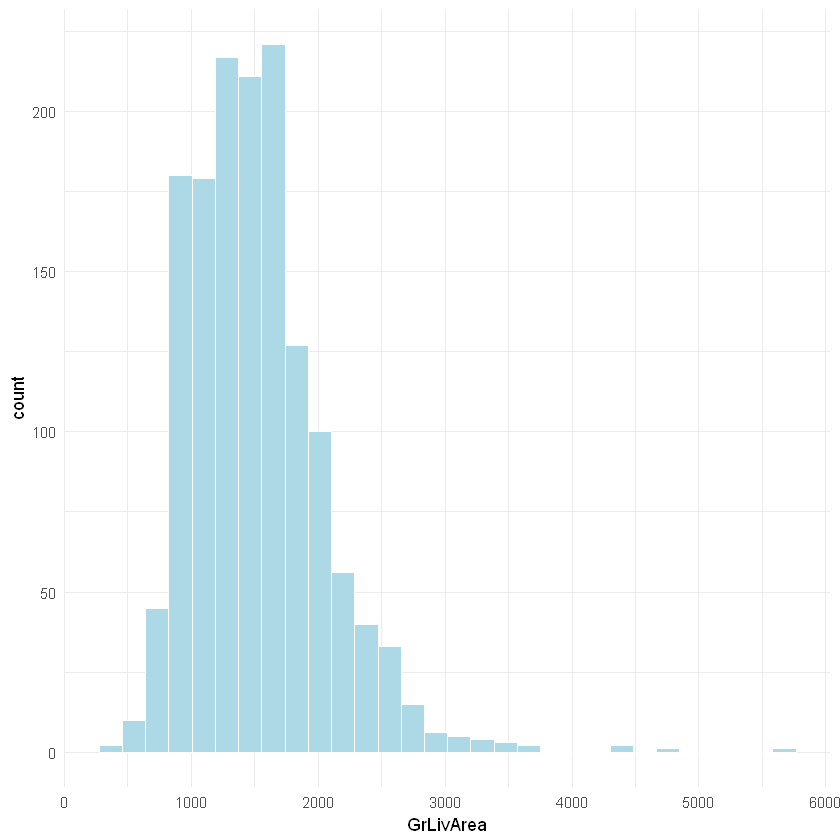

In [136]:
# 앞서 neighborhood 에서 본 것처럼, GrLivArea에서 이상로 의심되는 데이터가 있다.
# 이상치 의심 근거: 판매가격은 낮은데 GrLiveArea가 큼

# train set 과 test set을 다시 합침
train.test.df <- rbind(dplyr::select(train,-SalePrice), test)
train.test.df$type <- c(rep('train',1460),rep('test',1459))

#train set에서 GrLivArea 에 대한 히스토그램을 그림
ggplot(train, aes(x=GrLivArea)) +
  geom_histogram(fill='lightblue',color='white') +
  theme_minimal()

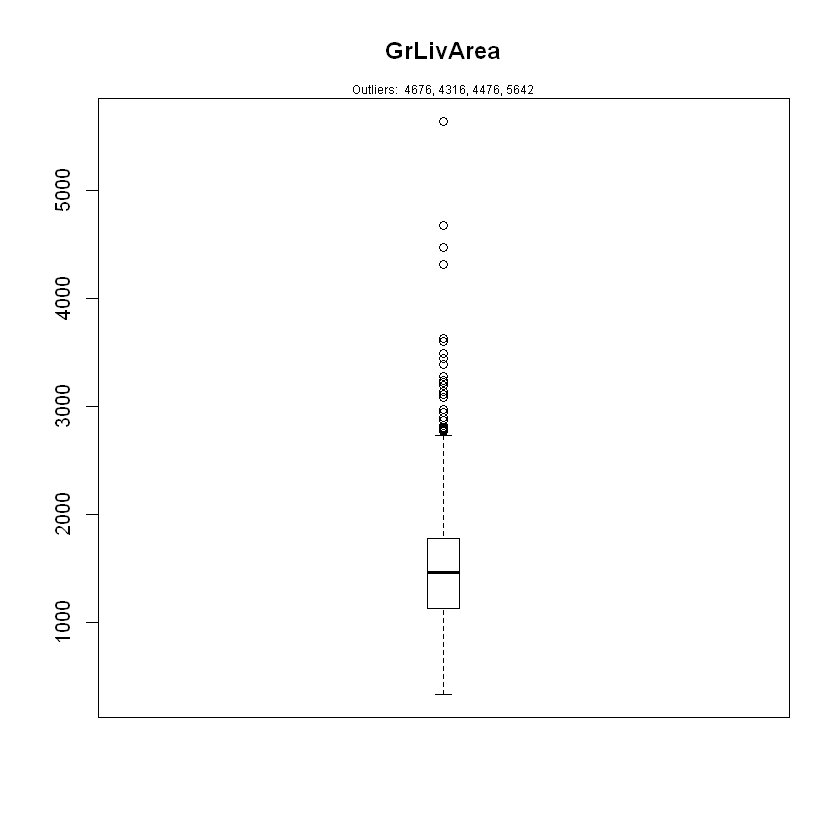

In [139]:
#GrLivArea 의 boxplot 그려줌 <-- boxplot 만으로 이상치 확인 가능
boxplot(train$GrLivArea, main="GrLivArea", boxwex=0.1)

# outlier변수 설정
outlier_values <- boxplot.stats(train$GrLivArea)$out

# outlier의 GrLivArea 값
mtext(paste("Outliers: ", paste(outlier_values[outlier_values>4000], collapse=", ")), cex=0.6)

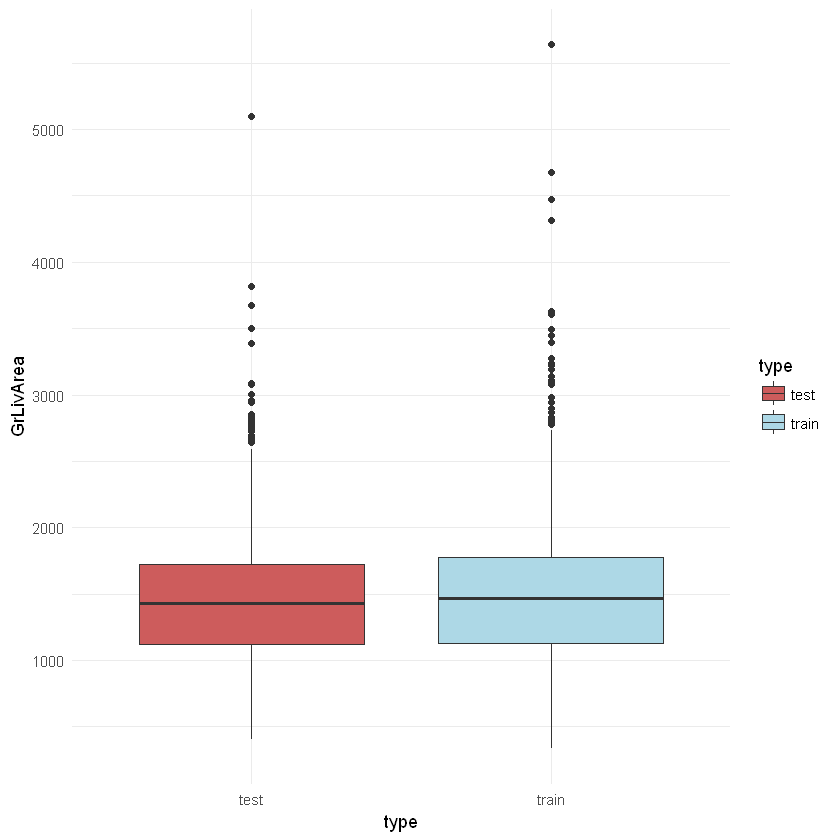

In [140]:
ggplot(train.test.df, aes(x=type, y=GrLivArea, fill=type)) +
  geom_boxplot() + #<- 이상치 보여줌
  theme_minimal() +
  scale_fill_manual(breaks = c("test", "train"), values = c("indianred", "lightblue"))

In [141]:
 idx.outliers <- which(train$GrLivArea > 4000)
df.numeric <- df.numeric[!1:nrow(df.numeric) %in% idx.outliers,]
df.combined <- df.combined[!1:nrow(df.combined) %in% idx.outliers,]

# df.numeric의 속성 확인 
dim(df.numeric)

[1] 2915   81

# Preprocessing

In [142]:
# Kolmogorov-Smirnof 검정 사용 
require(psych)
# linear models assume normality from dependant variables 
# transform any skewed data into normal
skewed <- apply(df.numeric, 2, skewness)
skewed <- skewed[(skewed > 0.8) | (skewed < -0.8)]

kurtosis <- apply(df.numeric, 2, kurtosi)
kurtosis <- kurtosis[(kurtosis > 3.0) | (kurtosis < -3.0)]

# not very useful in our case
ks.p.val <- NULL
for (i in 1:length(df.numeric)) {
  test.stat <- ks.test(df.numeric[i], rnorm(1000))
  ks.p.val[i] <- test.stat$p.value
}

for(col in names(skewed)){
  if(0 %in% df.numeric[, col]) {
    df.numeric[,col] <- log(1+df.numeric[,col])
  }
  else {
    df.numeric[,col] <- log(df.numeric[,col])
  }
}

# normalize the data
scaler <- preProcess(df.numeric)
df.numeric <- predict(scaler, df.numeric)

Loading required package: psych
Warning message:
"package 'psych' was built under R version 3.3.3"
Attaching package: 'psych'

The following objects are masked from 'package:scales':

    alpha, rescale

The following object is masked from 'package:randomForest':

    outlier

The following objects are masked from 'package:ggplot2':

    %+%, alpha

Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of

"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be approximate in the presence of ties"Warning message in ks.test(df.numeric[i], rnorm(1000)):
"p-value will be ap

In [143]:
# 카테고리 변수 --> 원핫 인코딩
dummy <- dummyVars(" ~ .",data=df.combined[,cat_features])
df.categoric <- data.frame(predict(dummy,newdata=df.combined[,cat_features]))

In [145]:
# saleprice와 상관계수가 높은 YearBuilt, GarageYrBlt and YearRemodAdd
# 1871년도 부터 20년 간격으로 2010 까지 총 7개의 bin을 생성 --> 시대에 따른 주택,차고 차별화
year.map = function(col.combined, col.name) {
  for (i in 1:7) {
    year.seq = seq(1871+(i-1)*20, 1871+i*20-1)
    idx = which(df.combined[,col.combined] %in% year.seq)
    df.categoric[idx,col.name] = i
  }
  return(df.categoric)
}

df.categoric['GarageYrBltBin'] = 0
df.categoric <- year.map('GarageYrBlt', 'GarageYrBltBin')
df.categoric['YearBuiltBin'] = 0
df.categoric <- year.map('YearBuilt','YearBuiltBin')
df.categoric['YearRemodAddBin'] = 0
df.categoric <- year.map('YearRemodAdd', 'YearRemodAddBin')

In [146]:
# * 뭐하는거지??
bin.cols <- c('GarageYrBltBin', 'YearBuiltBin', 'YearRemodAddBin')

for (col in bin.cols) {
  df.categoric <- cbind(df.categoric, model.matrix(~.-1, df.categoric[col]))
}
# lets drop the orginal 'GarageYrBltBin', 'YearBuiltBin', 'YearRemodAddBin' from our dataframe
df.categoric <- df.categoric[,!names(df.categoric) %in% bin.cols]

In [147]:
# 각 카테고리에 대한 작업 완료 후, 하나의 데이터 프레임으로 합침
df <- cbind(df.numeric, df.categoric)

Loading required package: WVPlots
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'WVPlots'"

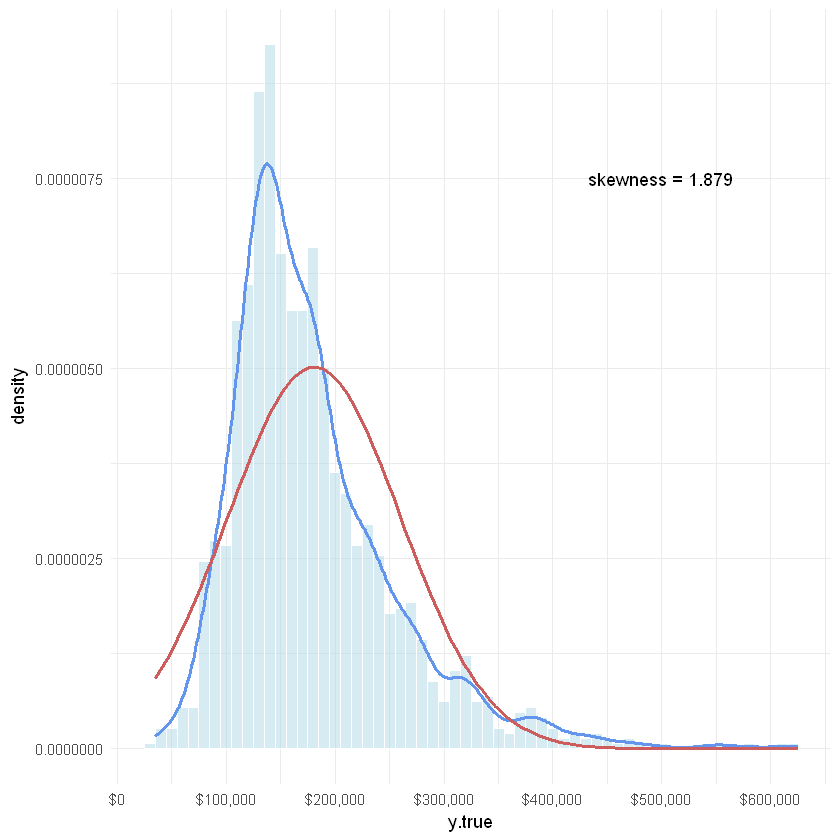

In [148]:
require(WVPlots)
y.true <- train$SalePrice[which(!1:1460 %in% idx.outliers)]

qplot(y.true, geom='density') +# +(train, aes(x=SalePrice)) +
  geom_histogram(aes(y=..density..), color='white', 
                 fill='lightblue', alpha=.5, bins = 60) +
  geom_line(aes(y=..density..), color='cornflowerblue', lwd = 1, stat = 'density') + 
  stat_function(fun = dnorm, colour = 'indianred', lwd = 1, args = 
                  list(mean(train$SalePrice), sd(train$SalePrice))) +
  scale_x_continuous(breaks = seq(0,800000,100000), labels = dollar) +
  scale_y_continuous(labels = comma) +
  theme_minimal() +
  annotate('text', label = paste('skewness =', signif(skewness(train$SalePrice),4)),
           x=500000,y=7.5e-06)


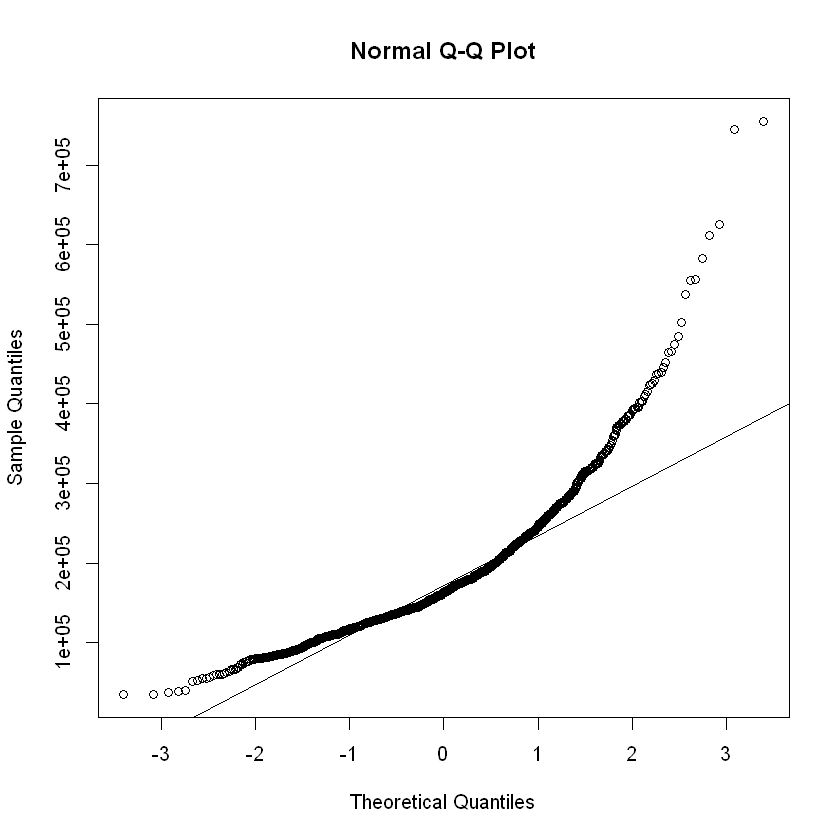

In [149]:
qqnorm(train$SalePrice)
qqline(train$SalePrice)

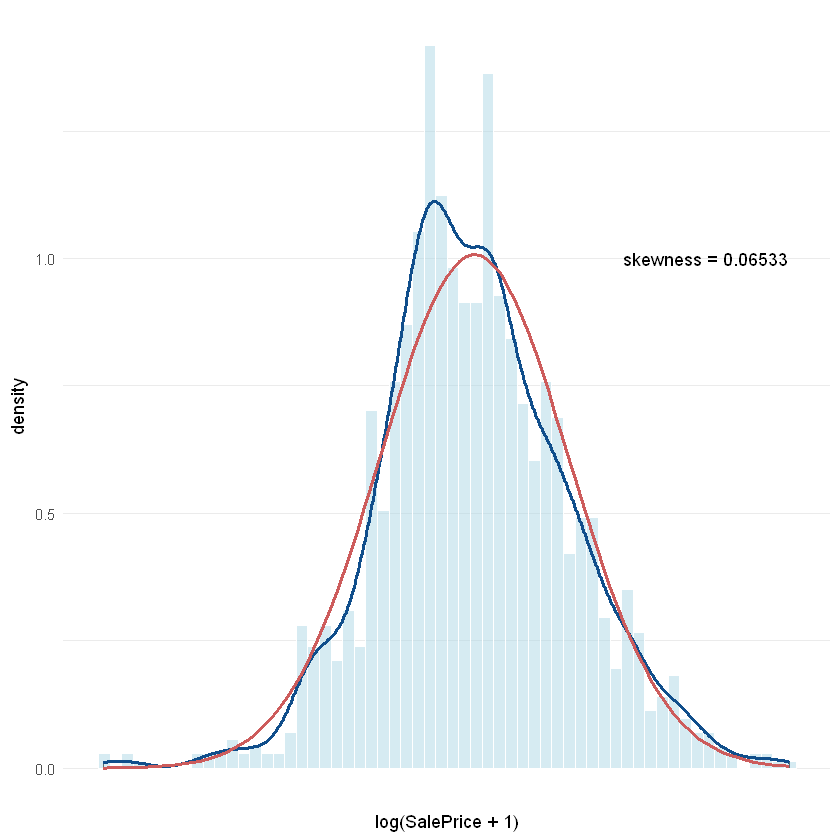

In [150]:
# salePrice 가 right-skew이므로 log 변환을 통해 정규화
y_train <- log(y.true+1)

qplot(y_train, geom = 'density') +
  geom_histogram(aes(y=..density..), color = 'white', fill = 'lightblue', alpha = .5, bins = 60) +
  scale_x_continuous(breaks = seq(0,800000,100000), labels = comma) +
  geom_line(aes(y=..density..), color='dodgerblue4', lwd = 1, stat = 'density') + 
  stat_function(fun = dnorm, colour = 'indianred', lwd = 1, args = 
                  list(mean(y_train), sd(y_train))) +
  #scale_x_continuous(breaks = seq(0,800000,100000), labels = dollar) +
  scale_y_continuous(labels = comma) +
  theme_minimal() +
  annotate('text', label = paste('skewness =', signif(skewness(y_train),4)),
           x=13,y=1) +
  labs(x = 'log(SalePrice + 1)') 

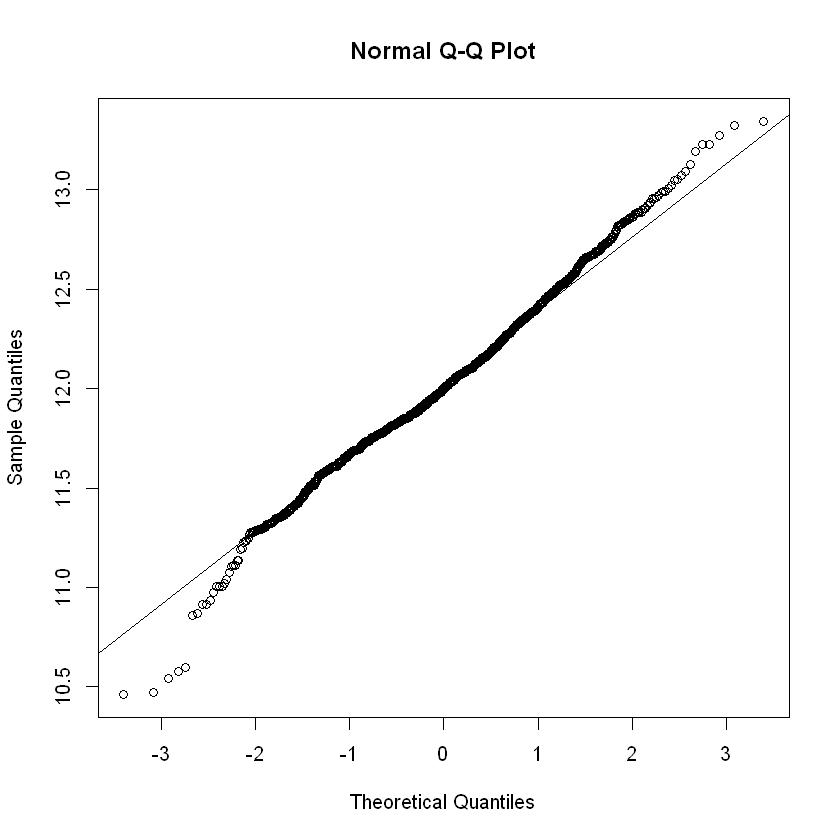

In [151]:
qqnorm(y_train)
qqline(y_train)

In [152]:
#log 변환 결과 정규성을 따름을 확인할 수 있다.
paste('The dataframe has', dim(df)[1], 'rows and', dim(df)[2], 'columns')

[1] "The dataframe has 2915 rows and 345 columns"

In [153]:
# 345 ocl = 기존 변수들 + 새로운 변수들
# 이중에서 Near-Zero Variance를 가지는 데이터를 빼준다 --> 이유) 과적합 야기
nzv.data <- nearZeroVar(df, saveMetrics = TRUE)

# take any of the near-zero-variance perdictors
drop.cols <- rownames(nzv.data)[nzv.data$nzv == TRUE]

df <- df[,!names(df) %in% drop.cols]

paste('The dataframe now has', dim(df)[1], 'rows and', dim(df)[2], 'columns')

[1] "The dataframe now has 2915 rows and 162 columns"

# Modeling with XGBoost 

In [154]:
# train set 과 test set 으로 나눠줌 
x_train <- df[1:1456,]

x_test <- df[1457:nrow(df),]


dtrain <- xgb.DMatrix(as.matrix(x_train), label = y_train)
dtest <- xgb.DMatrix(as.matrix(x_test))

In [155]:
cv.ctrl <- trainControl(method = "repeatedcv", repeats = 1,number = 4, 
                        allowParallel=T)

    xgb.grid <- expand.grid(nrounds = 750,
        eta = c(0.01,0.005,0.001),
        max_depth = c(4,6,8),
        colsample_bytree=c(0,1,10),
        min_child_weight = 2,
        subsample=c(0,0.2,0.4,0.6),
        gamma=0.01)
set.seed(45)
    #xgb_tune <- train(as.matrix(x_train),
    #        y_train,
    #        method="xgbTree",
    #        trControl=cv.ctrl,
    #        tuneGrid=xgb.grid,
    #        verbose=T,
    #        metric="RMSE",
    #        nthread =3)

xgb_params <- list(
  booster = 'gbtree',
  objective = 'reg:linear',
  colsample_bytree=1,
  eta=0.005,
  max_depth=4,
  min_child_weight=3,
  alpha=0.3,
  lambda=0.4,
  gamma=0.01, # less overfit
  subsample=0.6,
  seed=5,
  silent=TRUE)

#xgb.cv(xgb_params, dtrain, nrounds = 5000, nfold = 4, early_stopping_rounds = 500)

In [156]:
bst <- xgb.train(xgb_params,dtrain, nrounds = 1000)#, early_stopping_rounds = 300, watchlist = list(train=dtrain))

In [157]:
rmse_eval <- function(y.true, y.pred) {
  mse_eval <- sum((y.true - exp(y.pred)-1)^2) / length(y.true)
  return(sqrt(mse_eval))
}


## * issue
- MasVrnType 에서 MasVarArea 가 198 일때의 결측치 처리 --> 왜 BrkFace? // 내생각: Stone
- ln(66) 주석처리부분 -> 왜 한건지 이해안됨.